# Контекст

Ежемесячно активно используется более 1 миллиарда интеллектуальных мобильных устройств. Китай является крупнейшим рынком мобильной связи в мире и поэтому страдает от огромных объемов мошеннического трафика.

TalkingData, крупнейшая независимая платформа обслуживания больших данных в Китае, охватывает более 70% активных мобильных устройств по всей стране.

TalkingData попросила разработать алгоритм, который предсказывает, загрузит ли пользователь приложение после нажатия на рекламу мобильного приложения.

# Данные

Набор данных довольно огромен: ~8 ГБ и 200 миллионов наблюдений (train + тест) и соответствует определению данных о редких событиях, где 99,8% наблюдений являются отрицательными и только 0,2% наблюдений являются положительными.

In [1]:
# база
import numpy as np 
import pandas as pd 
import os
import warnings
import time



# визуализация
import seaborn as sns 
import matplotlib.pyplot as plt 

# pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
import pyspark.sql.functions as F
from pyspark.sql.functions import udf

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# torch
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn

# константы
RANDOM_STATE = 42
warnings.filterwarnings("ignore")
dir = 'E:/DATASETS/download_soft__clf/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
files = os.listdir(path = dir)

files

['app_count.csv',
 'channel_count.csv',
 'China_company__184_million_rows_pyspark_feature_preprocess.ipynb',
 'device_count.csv',
 'downsampled_train.csv',
 'ip_count.csv',
 'os_count.csv',
 'sample_submission.csv',
 'test.csv',
 'train',
 'train.csv',
 'train_sample.csv']

In [2]:
from pyspark.sql import SparkSession

app_name = 'Your App'


builder = (
    SparkSession
    .builder
    .appName(app_name)
)


spark = builder.getOrCreate()
spark

# Sample submission - формат вывода test.csv

- click_id - ссылка для прогнозирования
- is_attributed - не включено

In [3]:
sample_submission = spark.read.format('csv').option('header', 'true').load(dir + files[0])
sample_submission.show(3)

+---+---+-----+
|_c0|app|count|
+---+---+-----+
|  0|148| 4137|
|  1| 85| 3243|
|  2|251|  340|
+---+---+-----+
only showing top 3 rows



# test.csv - тестовый набор

In [4]:
test = spark.read.format('csv').option('header', 'true').load('E:/DATASETS/download_soft__clf/train.csv')
test.show(3)

+-----+---+------+---+-------+-------------------+---------------+-------------+
|   ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+-----+---+------+---+-------+-------------------+---------------+-------------+
|83230|  3|     1| 13|    379|2017-11-06 14:32:21|           NULL|            0|
|17357|  3|     1| 19|    379|2017-11-06 14:33:34|           NULL|            0|
|35810|  3|     1| 13|    379|2017-11-06 14:34:12|           NULL|            0|
+-----+---+------+---+-------+-------------------+---------------+-------------+
only showing top 3 rows



# train.csv / train_sample.csv - тренировочный и валидационная df


- ip - IP-адрес клика.
- app - идентификатор приложения для маркетинга.
- device - идентификатор типа устройства мобильного телефона пользователя (например, iphone 6 plus, iphone 7, huawei mate 7 и т. д.).
- os - идентификатор версии ОС мобильного телефона пользователя.
- channel - идентификатор канала издателя мобильной рекламы.
- click_time - временная метка клика (UTC)
- attributed_time - если пользователь загружает приложение после нажатия на рекламу, это время загрузки приложения.
- is_attributed - цель, которую необходимо спрогнозировать, указывая, что приложение было загружено.

In [5]:
train = spark.read.format('csv').option('header', 'true').load('E:/DATASETS/download_soft__clf/train.csv')
train.show(3)

+-----+---+------+---+-------+-------------------+---------------+-------------+
|   ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+-----+---+------+---+-------+-------------------+---------------+-------------+
|83230|  3|     1| 13|    379|2017-11-06 14:32:21|           NULL|            0|
|17357|  3|     1| 19|    379|2017-11-06 14:33:34|           NULL|            0|
|35810|  3|     1| 13|    379|2017-11-06 14:34:12|           NULL|            0|
+-----+---+------+---+-------+-------------------+---------------+-------------+
only showing top 3 rows



In [6]:
train = spark.read.csv('E:/DATASETS/download_soft__clf/train.csv',header=True, inferSchema= True)
train.printSchema()

root
 |-- ip: integer (nullable = true)
 |-- app: integer (nullable = true)
 |-- device: integer (nullable = true)
 |-- os: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- click_time: timestamp (nullable = true)
 |-- attributed_time: timestamp (nullable = true)
 |-- is_attributed: integer (nullable = true)



In [7]:
train.describe().show()

+-------+-----------------+------------------+-----------------+------------------+------------------+--------------------+
|summary|               ip|               app|           device|                os|           channel|       is_attributed|
+-------+-----------------+------------------+-----------------+------------------+------------------+--------------------+
|  count|        184903890|         184903890|        184903890|         184903890|         184903890|           184903890|
|   mean|90876.04196792723|12.011312758211847|21.72325165252067|22.677021402848798|268.57885623174286|0.002470721410998979|
| stddev|69527.89473043312|14.805210397714955|259.3326447188448| 55.25281738298106|129.58815206365384|0.049644908702075205|
|    min|                1|                 0|                0|                 0|                 0|                   0|
|    max|           364778|               768|             4227|               956|               500|                   1|
+-------

Посмотрим на метки. Большой ли дисбаланс классов ?

In [8]:
train.groupBy('is_attributed').count().show()

+-------------+---------+
|is_attributed|    count|
+-------------+---------+
|            1|   456846|
|            0|184447044|
+-------------+---------+



Дисбаланс классов: можно воспользоваться upsampling / downsampling в будущем. Пока продолжим исследование

# Посмотрим на пустые значения

In [9]:
for column in train.columns:
    print(
        column.ljust(20), train.filter(train[column].isNull()).count()
    )

ip                   0


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\oudel\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oudel\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oudel\AppData\Local\Programs\Python\Python311\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Множество пустых значений в признаке attributed_time (время скачивания) (этот признак есть у всех скачавших приложение
# смылса в этом признаке нет, т.к. задача классифицировать скачавших и не скачавших приложение) --> удалим его
train = train.drop('attributed_time')
train.columns

['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']

# Произведем DownSampling для пощады CPU

In [ ]:
train_class_1 = train.filter(train['is_attributed'] == 1) # малый (по размеру) класс
train_class_0 = train.filter(train['is_attributed'] == 0) # значительно больший класс

len_class_1 = train_class_1.count()
len_class_0 = train_class_0.count()

ratio =  len_class_1 / len_class_0

train_0_downsampled = train_class_0.sample(withReplacement = True,
                                           fraction = ratio,
                                           seed = RANDOM_STATE)

train = train_class_1.unionAll(train_0_downsampled)

In [ ]:
# df =\
# train.toPandas()

# df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
1,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1
2,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1
3,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1
4,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1
...,...,...,...,...,...,...,...,...
913206,41229,9,1,1,107,2017-11-09 15:59:59,NaT,0
913207,323897,15,1,19,153,2017-11-09 15:59:59,NaT,0
913208,30240,9,1,32,232,2017-11-09 16:00:00,NaT,0
913209,293332,18,1,3,107,2017-11-09 16:00:00,NaT,0


In [ ]:
# df.to_csv('downsampled_train.csv')

#### C Этого момента - рассмотриваем downsample набор но предподготовку будем делать на основе всего датасета

In [ ]:
df = pd.read_csv('downsampled_train.csv')
df = df.iloc[:,1:]

df.head()

C:\Users\oudel\AppData\Local\Temp\ipykernel_17980\564259947.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('downsampled_train.csv')


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1
1,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1
2,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1
3,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1
4,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1


# Рассмотрим каждый признак в отдельности

## ip (int)

In [ ]:
len(train.select('ip').distinct().collect()) # 277 396 уникальных значений ip

277396

In [ ]:
ip_count_data = train.groupBy('ip').count().orderBy(F.col('count').desc())
ip_count_data.show(5)

+-----+-------+
|   ip|  count|
+-----+-------+
| 5348|1238734|
| 5314|1171448|
|73516| 770451|
|73487| 763854|
|53454| 498186|
+-----+-------+
only showing top 5 rows



Сохраняем данные о ip и количестве кликов по каждому из них и делаем merge inner для коснтсруирования признака

ip можно считать аналогом географического положения устройства --> исключать признак не стоит.
Как можно предобработать такие данные?: Добавить признак количества кликов (каждая строка этого датасета - это клик по рекламе). Т.е. заменить ip адрес в каждой строке на количество кликов произведенных по этому ip.

In [ ]:
ip_count_frame = pd.read_csv('ip_count.csv').iloc[:,1:]
ip_count_frame.head()

,ip,count
0,5348,1238734
1,5314,1171448
2,73516,770451
3,73487,763854
4,53454,498186


Text(0.5, 1.0, 'Распределение количетва кликов по ip')

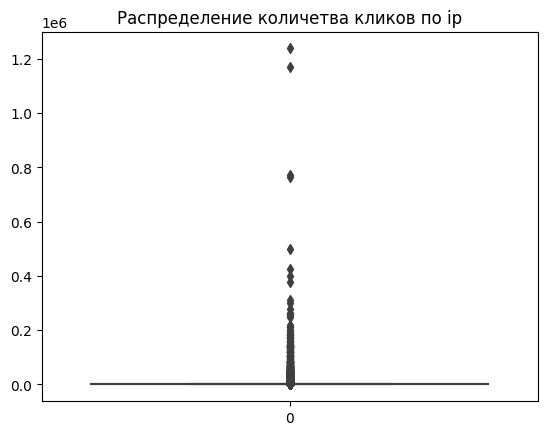

In [ ]:
sns.boxplot(
    ip_count_frame['count']
)
plt.title('Распределение количетва кликов по ip')

In [ ]:
df = df.merge(ip_count_frame,
              on = 'ip').rename({'count': 'count_ip_click'}, axis = 1)
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,count_ip_click
0,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494
1,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,3093
2,29692,19,6,29,213,2017-11-07 15:02:06,2017-11-07 15:03:09,1,3093
3,29692,84,0,24,101,2017-11-07 16:37:07,2017-11-08 04:53:50,1,3093
4,29692,27,1,47,122,2017-11-09 02:33:53,2017-11-09 15:07:47,1,3093


In [ ]:
df = df.drop('ip', axis = 1)
df.head()

,app,device,os,channel,click_time,attributed_time,is_attributed,count_ip_click
0,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494
1,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,3093
2,19,6,29,213,2017-11-07 15:02:06,2017-11-07 15:03:09,1,3093
3,84,0,24,101,2017-11-07 16:37:07,2017-11-08 04:53:50,1,3093
4,27,1,47,122,2017-11-09 02:33:53,2017-11-09 15:07:47,1,3093


## app (идентификатор приложения для маркетинга)

посмотрим на количество уникальных значений признака app в генеральном наборе

In [ ]:
len(train.select('app').distinct().collect())

417

сохраним количество кликов по каждому app - и сделаем новый признак из них (по аналогии с ip), т.к. идентификатор сам по себе (число) никакой смысловой нагрузки не несет

In [ ]:
app_count = \
train.groupBy('app').count().toPandas()

app_count.to_csv('app_count.csv')
app_count.head()

,app,count
0,148,4137
1,85,3243
2,251,340
3,137,2612
4,65,29473


<Axes: >

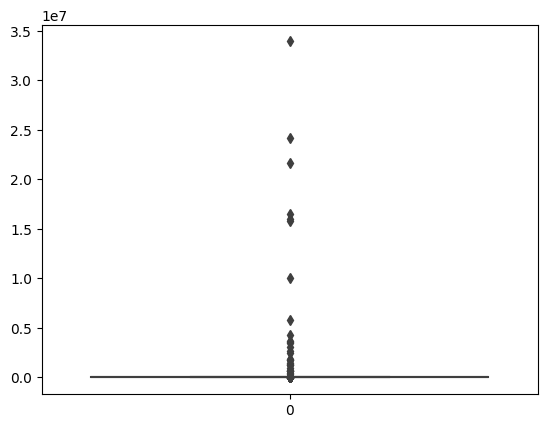

In [ ]:
sns.boxplot(app_count['count'])

In [ ]:
df = df.merge(app_count,
              on = 'app').rename({'count': 'count_app_click'}, axis = 1)
df.head()

,app,device,os,channel,click_time,attributed_time,is_attributed,count_ip_click,count_app_click
0,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494,91106
1,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,15626,91106
2,35,1,20,21,2017-11-06 16:29:54,2017-11-06 22:33:16,1,15626,91106
3,35,1,17,21,2017-11-07 03:02:15,2017-11-07 04:04:07,1,15626,91106
4,35,1,13,21,2017-11-07 10:59:00,2017-11-07 11:14:18,1,15626,91106


## device

In [ ]:
train.groupBy('device').count().show(5)

+------+-----+
|device|count|
+------+-----+
|   471|   12|
|   148|    4|
|   496|    3|
|  1645|    1|
|   833|    9|
+------+-----+
only showing top 5 rows



In [ ]:
len(train.select('device').distinct().collect())

1985

In [ ]:
device_count = \
train.groupBy('device').count().toPandas()

device_count.to_csv('device_count.csv')
device_count.head()

,device,count
0,148,106
1,737,242
2,31,23
3,251,672
4,3098,7


In [ ]:
device_count.sort_values(by = 'count', ascending =False)

,device,count
112,1,174330052
450,2,8105054
486,0,1033413
119,3032,692891
1416,3543,266596
...,...,...
2548,3609,1
2552,3855,1
2553,3592,1
2554,3801,1


<Axes: >

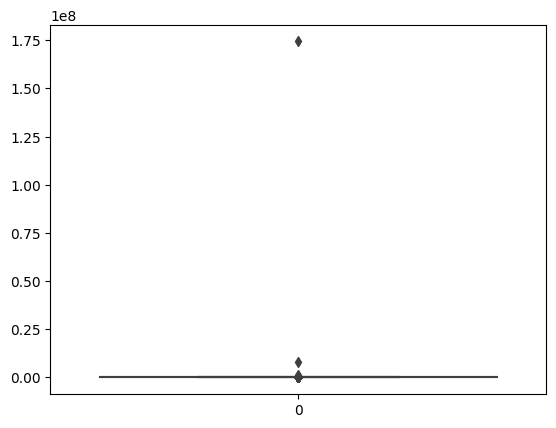

In [ ]:
sns.boxplot(device_count['count'])

In [ ]:
df = df.merge(device_count,
              on = 'device').rename({'count':'count_device_click'}, axis = 1)
df.head()

,app,device,os,channel,click_time,attributed_time,is_attributed,count_ip_click,count_app_click,count_device_click
0,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494,91106,174330052
1,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,15626,91106,174330052
2,35,1,20,21,2017-11-06 16:29:54,2017-11-06 22:33:16,1,15626,91106,174330052
3,35,1,17,21,2017-11-07 03:02:15,2017-11-07 04:04:07,1,15626,91106,174330052
4,35,1,13,21,2017-11-07 10:59:00,2017-11-07 11:14:18,1,15626,91106,174330052


## os 

In [ ]:
train.groupBy('os').count().show(5)

+---+------+
| os| count|
+---+------+
|148|  1089|
|243|    26|
| 31|767158|
| 85| 15746|
|137|  2367|
+---+------+
only showing top 5 rows



In [ ]:
len(train.select('os').distinct().collect())

800

In [ ]:
os_count = \
train.groupBy('os').count().toPandas()

os_count.to_csv('os_count.csv')
os_count.head()

,os,count
0,148,1089
1,243,26
2,31,767158
3,85,15746
4,137,2367


In [ ]:
df = df.merge(os_count,
              on = 'os').rename({'count':'count_os_click'}, axis = 1)

df = df.drop(['app', 'device', 'os'], axis = 1)
df.head()

,channel,click_time,attributed_time,is_attributed,count_ip_click,count_app_click,count_device_click,count_os_click
0,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494,91106,174330052,39782808
1,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,15626,91106,174330052,39782808
2,21,2017-11-07 10:59:00,2017-11-07 11:14:18,1,15626,91106,174330052,39782808
3,21,2017-11-09 02:22:05,2017-11-09 02:23:19,1,15626,91106,174330052,39782808
4,21,2017-11-08 03:59:28,2017-11-08 10:12:50,1,1283,91106,174330052,39782808


## channel

In [ ]:
train.groupBy('channel').count().show(5)

+-------+-------+
|channel|  count|
+-------+-------+
|    463| 942776|
|    471|     20|
|    243| 388347|
|    137|2302316|
|    451|   3322|
+-------+-------+
only showing top 5 rows



In [ ]:
len(train.select('channel').distinct().collect())

202

In [ ]:
channel_count =\
train.groupBy('channel').count().toPandas()

channel_count.to_csv('channel_count.csv')

channel_count.head()

,channel,count
0,463,942776
1,471,20
2,243,388347
3,137,2302316
4,451,3322


In [ ]:
df = df.merge(channel_count,
              on = 'channel').rename({'count':'count_channel_click'}, axis = 1)

df = df.drop('channel', axis = 1)
df.head()

,click_time,attributed_time,is_attributed,count_ip_click,count_app_click,count_device_click,count_os_click,count_channel_click
0,2017-11-06 15:41:07,2017-11-07 08:17:19,1,494,91106,174330052,39782808,303235
1,2017-11-06 16:00:02,2017-11-06 23:40:50,1,15626,91106,174330052,39782808,303235
2,2017-11-07 10:59:00,2017-11-07 11:14:18,1,15626,91106,174330052,39782808,303235
3,2017-11-09 02:22:05,2017-11-09 02:23:19,1,15626,91106,174330052,39782808,303235
4,2017-11-08 03:59:28,2017-11-08 10:12:50,1,1283,91106,174330052,39782808,303235


# click_time

In [ ]:
df['click_time'] = pd.to_datetime(df['click_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913211 entries, 0 to 913210
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   click_time           913211 non-null  datetime64[ns]
 1   attributed_time      456846 non-null  object        
 2   is_attributed        913211 non-null  int64         
 3   count_ip_click       913211 non-null  int64         
 4   count_app_click      913211 non-null  int64         
 5   count_device_click   913211 non-null  int64         
 6   count_os_click       913211 non-null  int64         
 7   count_channel_click  913211 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 62.7+ MB


In [ ]:
print('Минимальное время фрейма: ' , df['click_time'].min())
print('Максимальное время фрейма: ' , df['click_time'].max())

Минимальное время фрейма:  2017-11-06 15:41:07
Максимальное время фрейма:  2017-11-09 16:00:00


все время сфокусировано в одном месяце, поэтому за признаки возьмем день, час, минута (это резонно, т.к. по сути итоговая задача выявить мошенников, а большое количество запросов на сервер за короткое время - это один из признаков мошенничества)

In [ ]:
df['day_click'] = df['click_time'].dt.day
df['hour_click'] = df['click_time'].dt.hour
df['minute_click'] = df['click_time'].dt.minute
df = df.drop('click_time', axis = 1)
df.head()

,attributed_time,is_attributed,count_ip_click,count_app_click,count_device_click,count_os_click,count_channel_click,day_click,hour_click,minute_click
0,2017-11-07 08:17:19,1,494,91106,174330052,39782808,303235,6,15,41
1,2017-11-06 23:40:50,1,15626,91106,174330052,39782808,303235,6,16,0
2,2017-11-07 11:14:18,1,15626,91106,174330052,39782808,303235,7,10,59
3,2017-11-09 02:23:19,1,15626,91106,174330052,39782808,303235,9,2,22
4,2017-11-08 10:12:50,1,1283,91106,174330052,39782808,303235,8,3,59


## attributed_time

Мы уже проверяли этот признак на генеральном фрейме - черезчур много пропусков + признак, с точки зрения моделирования не носит в себе информации (понятно, что те, кто скачивают приложение - у тех есть время его загрузки) --> удаляем признак

In [ ]:
df = df.drop('attributed_time', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913211 entries, 0 to 913210
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   is_attributed        913211 non-null  int64
 1   count_ip_click       913211 non-null  int64
 2   count_app_click      913211 non-null  int64
 3   count_device_click   913211 non-null  int64
 4   count_os_click       913211 non-null  int64
 5   count_channel_click  913211 non-null  int64
 6   day_click            913211 non-null  int64
 7   hour_click           913211 non-null  int64
 8   minute_click         913211 non-null  int64
dtypes: int64(9)
memory usage: 69.7 MB


In [ ]:
df

Это была предварительная обработка - если будущие модели покажут плохой результат --> вернемся к обработке

In [ ]:
df.to_csv('train/train_preprocess_1.csv',
          index = False)

In [6]:
data = pd.read_csv('train/train_preprocess_1.csv').iloc[:,1:]
data

,is_attributed,count_ip_click,count_app_click,count_device_click,count_os_click,count_channel_click,day_click,hour_click,minute_click
0,1,494,91106,174330052,39782808,303235,6,15,41
1,1,15626,91106,174330052,39782808,303235,6,16,0
2,1,15626,91106,174330052,39782808,303235,7,10,59
3,1,15626,91106,174330052,39782808,303235,9,2,22
4,1,1283,91106,174330052,39782808,303235,8,3,59
...,...,...,...,...,...,...,...,...,...
913206,0,33149,1933,1468,109,1468,7,9,48
913207,0,7658,1933,1468,104,1468,8,6,14
913208,0,15310,1933,1468,273,1468,9,14,58
913209,0,2611,1933,1468,172,1468,7,15,14


In [7]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,is_attributed,count_ip_click,count_app_click,count_device_click,count_os_click,count_channel_click,day_click,hour_click,minute_click
is_attributed,1.000000,-0.071729,-0.629311,-0.348364,-0.183363,-0.476580,0.012518,-0.058264,0.000985
count_ip_click,-0.071729,1.000000,0.047442,-0.013750,0.015697,0.038209,-0.003581,0.054999,-0.000382
count_app_click,-0.629311,0.047442,1.000000,0.312040,0.173777,0.560009,-0.002732,0.012542,-0.003981
count_device_click,-0.348364,-0.013750,0.312040,1.000000,0.403004,0.221965,-0.024599,-0.064855,-0.003450
count_os_click,-0.183363,0.015697,0.173777,0.403004,1.000000,0.129780,-0.025857,-0.029918,-0.004783
count_channel_click,-0.476580,0.038209,0.560009,0.221965,0.129780,1.000000,-0.011051,-0.009693,-0.005454
day_click,0.012518,-0.003581,-0.002732,-0.024599,-0.025857,-0.011051,1.000000,-0.253098,0.001134
hour_click,-0.058264,0.054999,0.012542,-0.064855,-0.029918,-0.009693,-0.253098,1.000000,-0.004463
minute_click,0.000985,-0.000382,-0.003981,-0.003450,-0.004783,-0.005454,0.001134,-0.004463,1.000000


# Модель Pytorch

## Подготовка ко входу в модель

### Импорт наборов

In [ ]:
data_val = pd.read_csv('train_sample.csv')
data_train = pd.read_csv('downsampled_train.csv').iloc[:,1:]


data_train = data_train.sample(frac = 1,
                               random_state = RANDOM_STATE)

## Пишим трансформатор выборки для входа в модель

In [256]:
ip_count_frame = pd.read_csv('ip_count.csv').iloc[:,1:]
app_count = pd.read_csv('app_count.csv').iloc[:,1:]
device_count = pd.read_csv('device_count.csv').iloc[:,1:]
os_count = pd.read_csv('os_count.csv').iloc[:,1:]
channel_count = pd.read_csv('channel_count.csv').iloc[:,1:]

def column_preprocess_function(data):

    save_data_index = data.index

    data = data.reset_index().merge(ip_count_frame,
                                    on  = 'ip',
                                    how = 'left')\
                             .rename({'count': 'count_ip_click'}, axis = 1)\
                             .drop('ip', axis = 1)
    data = data.merge(app_count,
                      on = 'app',
                      how = 'left').rename({'count': 'count_app_click'}, axis = 1).drop('app', axis = 1)
    data = data.merge(device_count,
                      on = 'device',
                      how = 'left').rename({'count': 'count_device_click'}, axis = 1).drop('device', axis = 1)
    data = data.merge(os_count,
                      on = 'os',
                      how = 'left').rename({'count': 'count_os_click'}, axis = 1).drop('os', axis = 1)
    data = data.merge(channel_count,
                      on = 'channel',
                      how = 'left')\
               .rename({'count': 'count_channel_click'}, axis = 1)\
               .drop('channel', axis = 1)\
               .set_index('index')
    
    data['click_time'] = pd.to_datetime(data['click_time'])
    data['day_click'] = data['click_time'].dt.day
    data['hour_click'] = data['click_time'].dt.hour
    data['minute_click'] = data['click_time'].dt.minute
    data = data.drop('click_time', axis = 1)

    data = data.drop('attributed_time', axis = 1)
    return data.loc[save_data_index]


In [257]:
scaler = MinMaxScaler()
num_columns = data_train.drop('is_attributed', axis = 1).columns

from sklearn.preprocessing import FunctionTransformer

num_features_transformer = Pipeline(steps = [
    ('column_preprocess', FunctionTransformer(column_preprocess_function)),
    ('scaler', scaler)
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_features_transformer, num_columns)
])

# Модель

In [281]:
def ChinaNew(output1):

    model2 = nn.Sequential(
        nn.Linear(8, output1),
        nn.Tanh(),


        nn.Linear(output1, output1*4),
        nn.Tanh(),


        nn.Linear(output1*4, output1*2),
        nn.Tanh(),


        nn.Linear(output1*2, output1),
        nn.Tanh(),

        nn.Linear(output1, 1))

    return model2

# Цикл обучения

In [259]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg

In [306]:
def training_loop(
          
          epoches,
          model,
          loss_fn,
          optim,

          X_train, y_train,
          X_val, y_val

          # reg_type  # 'l1' / 'l2' / 'l1_l2'
):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    # модель переносим в CUDA    
    model = model.to(device)
    loss_fn = loss_fn.to(device)


    X_train = preprocessor.fit_transform(X_train)
    X_train = torch.tensor(X_train, dtype = torch.float32)

    # X_val не предподготовлен --> используем pipeline и также помещаем в тензор
    X_val = preprocessor.fit_transform(X_val)
    X_val = torch.tensor(X_val, dtype = torch.float32)

    # Таже метки необходимо перевести во float() тип
    y_train = torch.tensor(y_train.to_numpy()).float()
    y_val = torch.tensor(y_val.to_numpy()).float()

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(1, epoches+1):

            model.train()
            optim.zero_grad()


            predict_train = model(X_train).view(-1,1)
            y_train = y_train.view(-1,1)

            loss = loss_fn(predict_train, y_train)
            '''loss = loss_with_l1_or_l2_regulizer(model = model,
                                                type = 'l2',
                                                l_lambda = 0.001,
                                                loss_by_fn = loss)'''

            train_loss_list.append(loss.item())

        
            loss.backward()
            optim.step()

            model.eval()
            with torch.no_grad():

                probas_train = torch.sigmoid(predict_train)
                predict_train_class = (probas_train + 0.5).int().float()
                acc_train = ((predict_train_class == y_train).sum().item() / len(y_train))
                train_accuracy_list.append(acc_train)



                predict_val = model(X_val).view(-1,1)
                y_val = y_val.view(-1,1)
                loss_val = loss_fn(predict_val, y_val)
                '''loss_val = loss_with_l1_or_l2_regulizer(model = model,
                                                        type = 'l2',
                                                        l_lambda = 0.001,
                                                        loss_by_fn = loss_val)'''
                val_loss_list.append(loss_val.item())


                probas_val = torch.sigmoid(predict_val)
                predict_val_class = (probas_val + 0.5).int().float()
                acc_val = ((predict_val_class == y_val).sum().item() / len(y_val))
                val_accuracy_list.append(acc_val)




            if epoch == 1 or epoch % 100 == 0:
                print(
                    'Epoch {}/{} : train loss: {:.3f}, val loss: {:.3f}, train accuracy: {:.4f}, val accuracy: {:.4f}'.\
                    
                    format(epoch, epoches, loss.item(), loss_val.item(), acc_train, acc_val)
                )
    
    train_reserch_accuracy_after_100_epoch = max(train_accuracy_list[100:])
    val_reserch_accuracy_after_100_epoch = max(val_accuracy_list[100:])

    print('\nМаксимальное значение точности на ТРЕНИРОВКЕ: {:.3f} эпоха - {}'.format(train_reserch_accuracy_after_100_epoch,
                                                                                 np.argmax(train_accuracy_list[100:]) + 100))
    
    print('\nМаксимальное значение точности на ВАЛИДАЦИИ: {:.3f} эпоха - {}'.format(val_reserch_accuracy_after_100_epoch,
                                                                                 np.argmax(val_accuracy_list[100:]) + 100))



    x = range(1, epoches + 1)

    plt.figure(figsize = (15,10))
    plt.subplot(2,1,1)
    sns.lineplot(x = x,
                    y = train_loss_list,
                    label = 'тренировочные',
                    color = 'red')
    sns.lineplot(x = x,
                    y = val_loss_list,
                    label = 'валидационные',
                    color = 'green')
    plt.grid()
    plt.legend()
    plt.xlabel('эпоха')
    plt.ylabel('loss')
    plt.title('Потеря и точность на тренировочной и валидационной выборке')

    plt.subplot(2,1,2)
    sns.lineplot(x = x,
                    y = train_accuracy_list,
                    label = 'тренировочная',
                    color = 'red')
    sns.lineplot(x = x,
                    y = val_accuracy_list,
                    label = 'валидационная',
                    color = 'green')
    plt.grid()
    plt.xlabel('эпоха')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return train_reserch_accuracy_after_100_epoch,\
           val_reserch_accuracy_after_100_epoch,\
           train_accuracy_list,\
           val_accuracy_list

# Пробуем Upsampling на валидационной выборке

In [262]:
data_val['is_attributed'].value_counts()

is_attributed
0    99773
1      227
Name: count, dtype: int64

In [263]:
data_val_class_0 = data_val[data_val['is_attributed'] == 0]
data_val_class_1 = data_val[data_val['is_attributed'] == 1]

len_class_0 = len(data_val_class_0)
len_class_1 = len(data_val_class_1)

ratio = int(len_class_0 / len_class_1)

data_val_class_1 = data_val_class_1.loc[data_val_class_1.index.repeat(ratio)]

data_val_balance = pd.concat([data_val_class_0,
                              data_val_class_1], ignore_index = True).sample(frac = 1)

data_val_balance['is_attributed'].value_counts()

is_attributed
0    99773
1    99653
Name: count, dtype: int64

In [264]:
y_val_balance_upsample = data_val_balance['is_attributed']
X_val_balance_upsample = data_val_balance.drop('is_attributed', axis = 1)

In [265]:
y_train = data_train['is_attributed']
X_train = data_train.drop('is_attributed', axis = 1)

Epoch 1/1000 : train loss: 0.697, val loss: 0.696, train accuracy: 0.5003, val accuracy: 0.4997
Epoch 100/1000 : train loss: 0.398, val loss: 0.361, train accuracy: 0.8427, val accuracy: 0.8567
Epoch 200/1000 : train loss: 0.315, val loss: 0.277, train accuracy: 0.8932, val accuracy: 0.9138
Epoch 300/1000 : train loss: 0.300, val loss: 0.261, train accuracy: 0.8998, val accuracy: 0.9217
Epoch 400/1000 : train loss: 0.296, val loss: 0.257, train accuracy: 0.8999, val accuracy: 0.9225
Epoch 500/1000 : train loss: 0.293, val loss: 0.254, train accuracy: 0.9002, val accuracy: 0.9223
Epoch 600/1000 : train loss: 0.288, val loss: 0.248, train accuracy: 0.9002, val accuracy: 0.9228
Epoch 700/1000 : train loss: 0.284, val loss: 0.244, train accuracy: 0.9006, val accuracy: 0.9232
Epoch 800/1000 : train loss: 0.282, val loss: 0.242, train accuracy: 0.9006, val accuracy: 0.9235
Epoch 900/1000 : train loss: 0.280, val loss: 0.239, train accuracy: 0.9008, val accuracy: 0.9241
Epoch 1000/1000 : trai

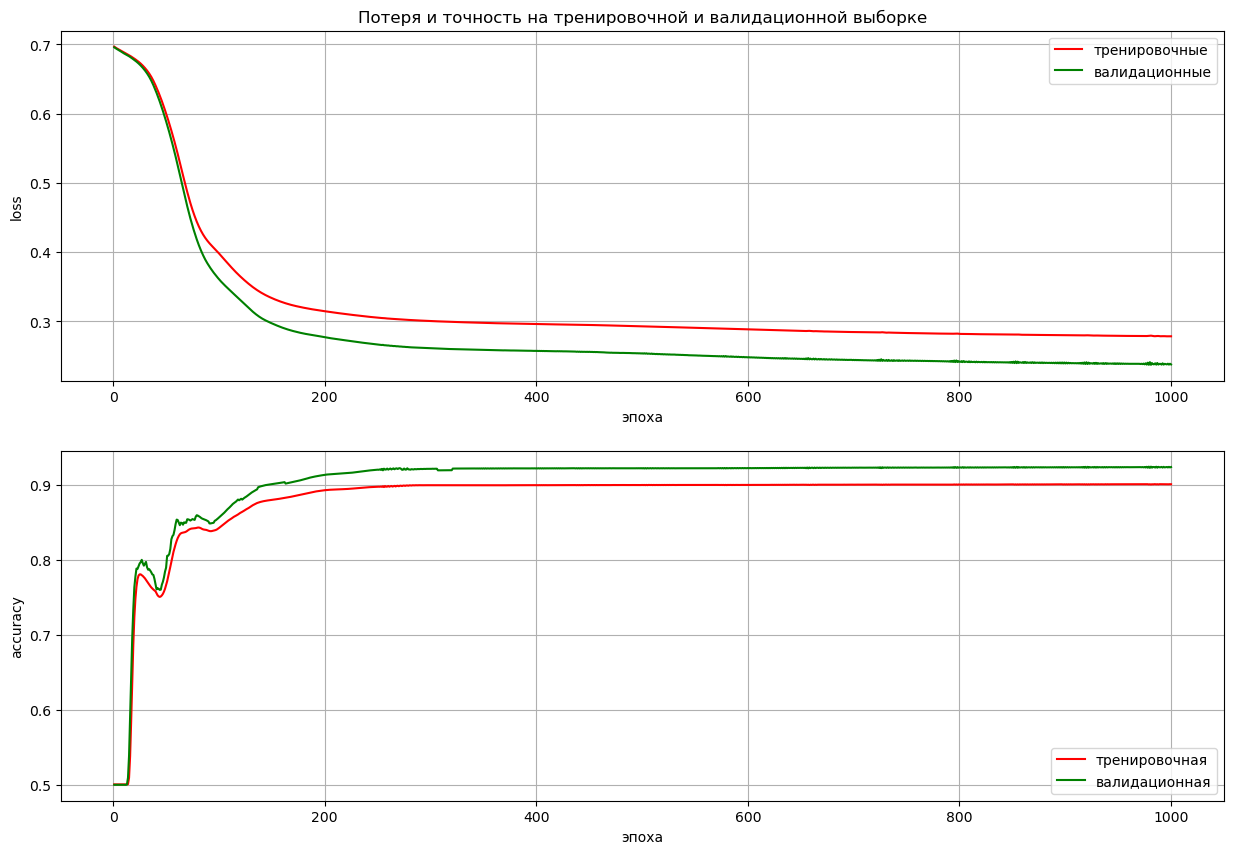

(0.901248451891184, 0.9246687994544343)

In [266]:
model3 = ChinaNew(16)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model3.parameters(), lr = 0.001)

training_loop(

    epoches = 1000,
    model = model3,
    loss_fn = loss_fn,
    optim = optim,

    X_train = X_train,
    y_train = y_train,

    X_val = X_val_balance_upsample,
    y_val = y_val_balance_upsample
)

# Пробуем Downsampling на валидационной выборке

In [267]:
train_sample = pd.read_csv('train_sample.csv')
train_sample = train_sample.sample(frac =  1)

class_0 = train_sample[train_sample['is_attributed'] == 0]
class_1 = train_sample[train_sample['is_attributed'] == 1]

class_0 = class_0.sample(n = 227,
                         random_state = RANDOM_STATE)
data_ = pd.concat([class_0, class_1], axis = 0, ignore_index = True).sample(frac = 1)
data_.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
96,97623,3,1,19,442,2017-11-08 01:13:05,NaN,0
18,167104,27,1,22,122,2017-11-09 05:07:57,NaN,0
93,154699,12,1,19,328,2017-11-08 15:50:02,NaN,0
401,178824,5,1,27,113,2017-11-07 08:49:16,2017-11-07 08:49:54,1
311,180702,10,1,7,113,2017-11-07 11:10:18,2017-11-07 11:10:53,1


In [268]:
data_['is_attributed'].value_counts()

is_attributed
0    227
1    227
Name: count, dtype: int64

In [269]:
y_val_balance_down = data_['is_attributed']
X_val_balance_down = data_.drop('is_attributed', axis = 1)

Epoch 1/1000 : train loss: 0.690, val loss: 0.682, train accuracy: 0.5003, val accuracy: 0.7467
Epoch 100/1000 : train loss: 0.342, val loss: 0.295, train accuracy: 0.8788, val accuracy: 0.8921
Epoch 200/1000 : train loss: 0.307, val loss: 0.253, train accuracy: 0.8979, val accuracy: 0.9295
Epoch 300/1000 : train loss: 0.299, val loss: 0.245, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.296, val loss: 0.241, train accuracy: 0.8999, val accuracy: 0.9317
Epoch 500/1000 : train loss: 0.293, val loss: 0.235, train accuracy: 0.8996, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.290, val loss: 0.232, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.288, val loss: 0.229, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.284, val loss: 0.227, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 900/1000 : train loss: 0.280, val loss: 0.222, train accuracy: 0.9005, val accuracy: 0.9295
Epoch 1000/1000 : trai

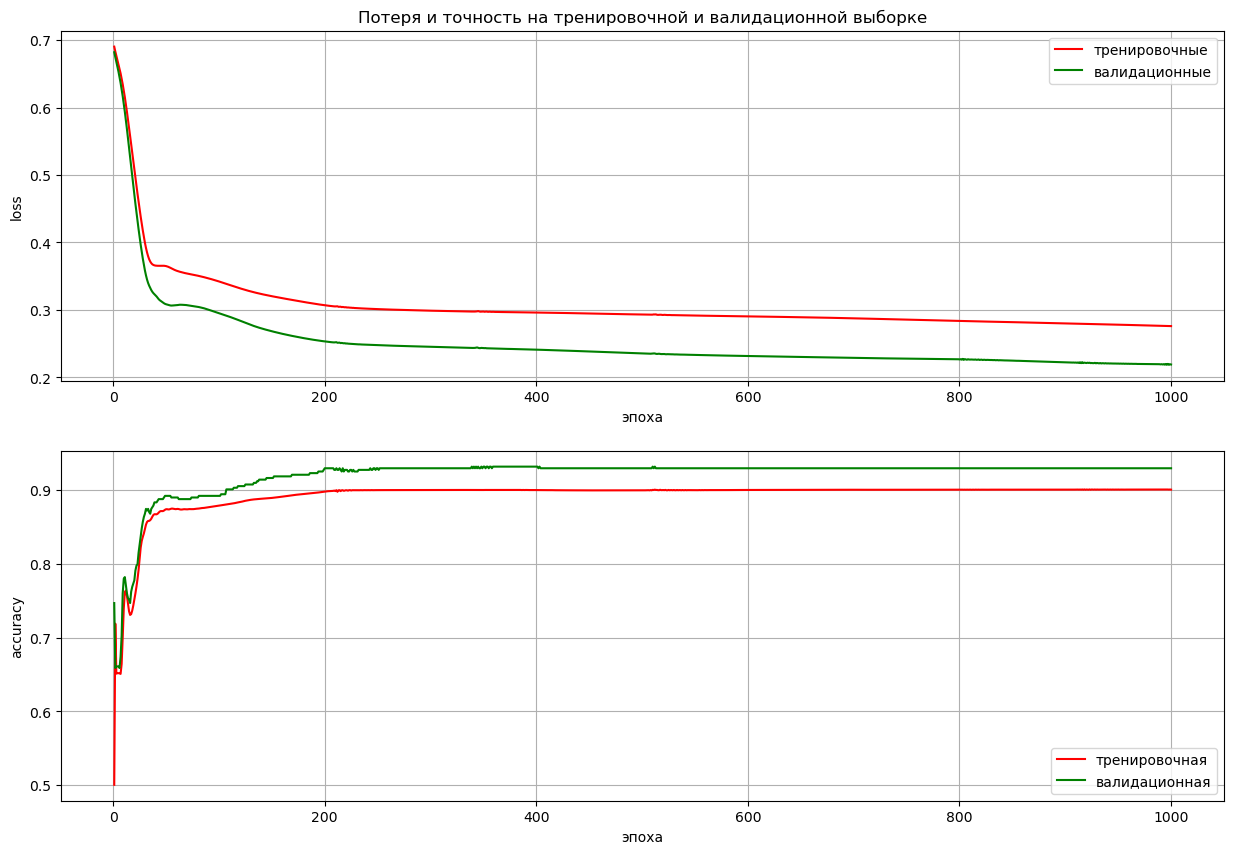

(0.9008356228735747, 0.9317180616740088)

In [283]:
model3 = ChinaNew(32)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model3.parameters(), lr = 0.001)

training_loop(

    epoches = 1000,
    model = model3,
    loss_fn = loss_fn,
    optim = optim,

    X_train = X_train,
    y_train = y_train,

    X_val = X_val_balance_down,
    y_val = y_val_balance_down
)


# Отбор наилучшей модели

learning rate = 0.001
 num_neuros = 16
 optim = Adam
 epoches = 1000 

Epoch 1/1000 : train loss: 0.694, val loss: 0.691, train accuracy: 0.4997, val accuracy: 0.5000
Epoch 100/1000 : train loss: 0.351, val loss: 0.303, train accuracy: 0.8783, val accuracy: 0.8899
Epoch 200/1000 : train loss: 0.323, val loss: 0.273, train accuracy: 0.8904, val accuracy: 0.9185
Epoch 300/1000 : train loss: 0.307, val loss: 0.253, train accuracy: 0.8997, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.301, val loss: 0.248, train accuracy: 0.9000, val accuracy: 0.9251
Epoch 500/1000 : train loss: 0.299, val loss: 0.246, train accuracy: 0.9002, val accuracy: 0.9273
Epoch 600/1000 : train loss: 0.297, val loss: 0.245, train accuracy: 0.9000, val accuracy: 0.9273
Epoch 700/1000 : train loss: 0.297, val loss: 0.244, train accuracy: 0.8998, val accuracy: 0.9273
Epoch 800/1000 : train loss: 0.296, val loss: 0.243, train accuracy: 0.8997, val accuracy: 0.9295
Epoch 900/1000 : train loss: 0.295, val loss: 0.2

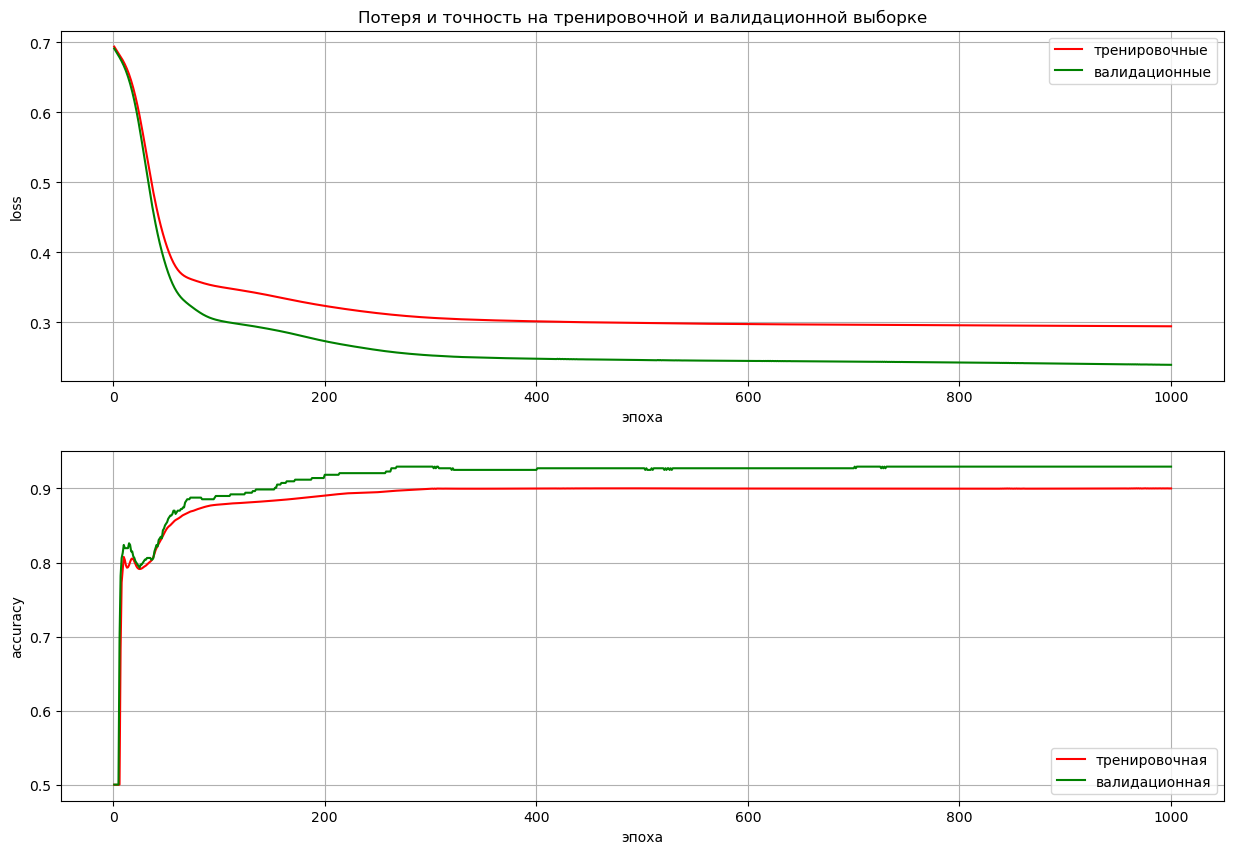

Время выполнения:  18.85083246231079
learning rate = 0.001
 num_neuros = 16
 optim = SGD
 epoches = 1000 

Epoch 1/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 100/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 200/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 300/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 500/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 900/100

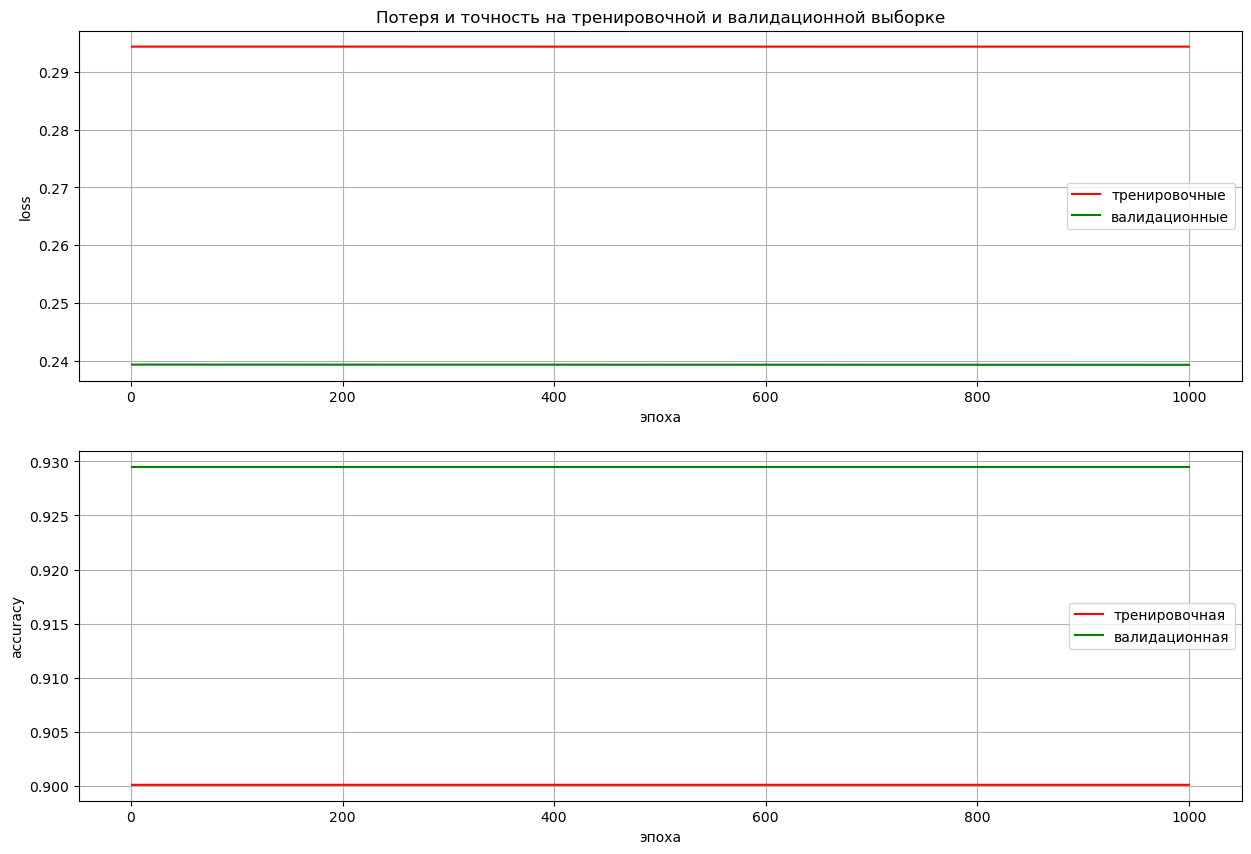

Время выполнения:  18.517537593841553
learning rate = 0.001
 num_neuros = 32
 optim = Adam
 epoches = 1000 

Epoch 1/1000 : train loss: 0.692, val loss: 0.685, train accuracy: 0.5270, val accuracy: 0.7885
Epoch 100/1000 : train loss: 0.325, val loss: 0.277, train accuracy: 0.8865, val accuracy: 0.9031
Epoch 200/1000 : train loss: 0.303, val loss: 0.249, train accuracy: 0.8998, val accuracy: 0.9273
Epoch 300/1000 : train loss: 0.298, val loss: 0.246, train accuracy: 0.9002, val accuracy: 0.9273
Epoch 400/1000 : train loss: 0.296, val loss: 0.242, train accuracy: 0.8995, val accuracy: 0.9295
Epoch 500/1000 : train loss: 0.292, val loss: 0.235, train accuracy: 0.8997, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.287, val loss: 0.230, train accuracy: 0.9000, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.282, val loss: 0.227, train accuracy: 0.9005, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.278, val loss: 0.224, train accuracy: 0.9005, val accuracy: 0.9295
Epoch 900/1

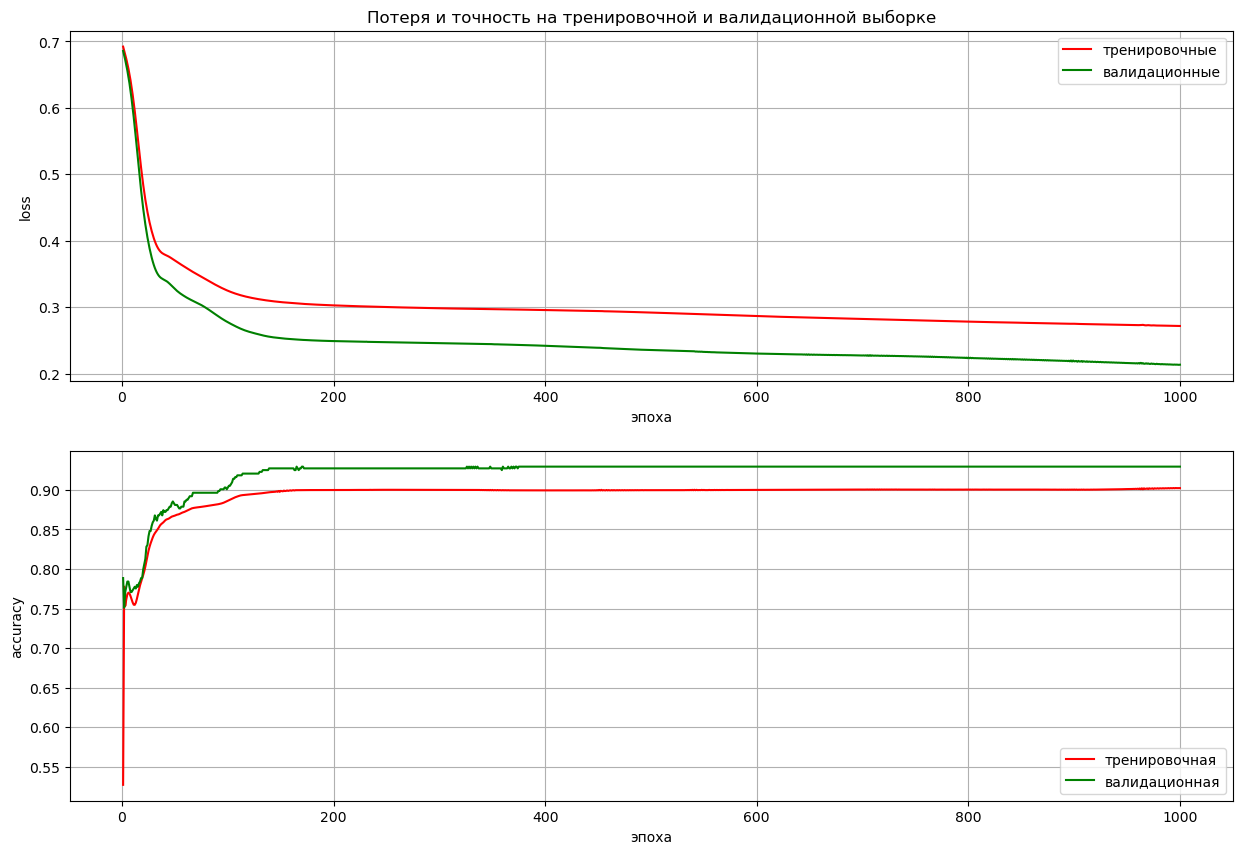

Время выполнения:  32.312830448150635
learning rate = 0.001
 num_neuros = 32
 optim = SGD
 epoches = 1000 

Epoch 1/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9026, val accuracy: 0.9295
Epoch 100/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 200/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 300/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 500/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.272, val loss: 0.213, train accuracy: 0.9024, val accuracy: 0.9295
Epoch 900/10

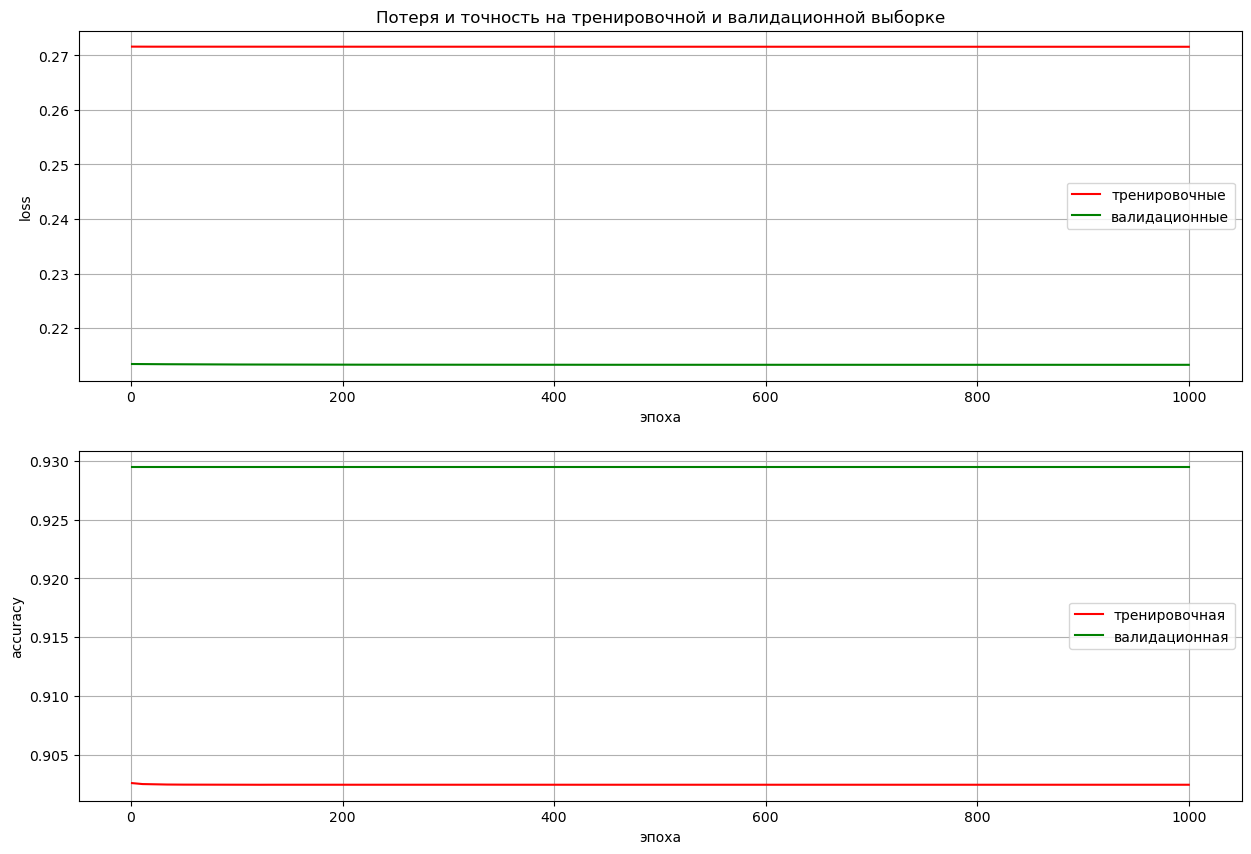

Время выполнения:  32.65411353111267
learning rate = 0.01
 num_neuros = 16
 optim = Adam
 epoches = 1000 

Epoch 1/1000 : train loss: 0.694, val loss: 0.681, train accuracy: 0.5003, val accuracy: 0.5000
Epoch 100/1000 : train loss: 0.299, val loss: 0.245, train accuracy: 0.9002, val accuracy: 0.9295
Epoch 200/1000 : train loss: 0.295, val loss: 0.238, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 300/1000 : train loss: 0.301, val loss: 0.237, train accuracy: 0.8998, val accuracy: 0.9317
Epoch 400/1000 : train loss: 0.292, val loss: 0.227, train accuracy: 0.9005, val accuracy: 0.9317
Epoch 500/1000 : train loss: 0.286, val loss: 0.226, train accuracy: 0.9002, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.285, val loss: 0.226, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.281, val loss: 0.225, train accuracy: 0.9008, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.280, val loss: 0.224, train accuracy: 0.9011, val accuracy: 0.9295
Epoch 900/100

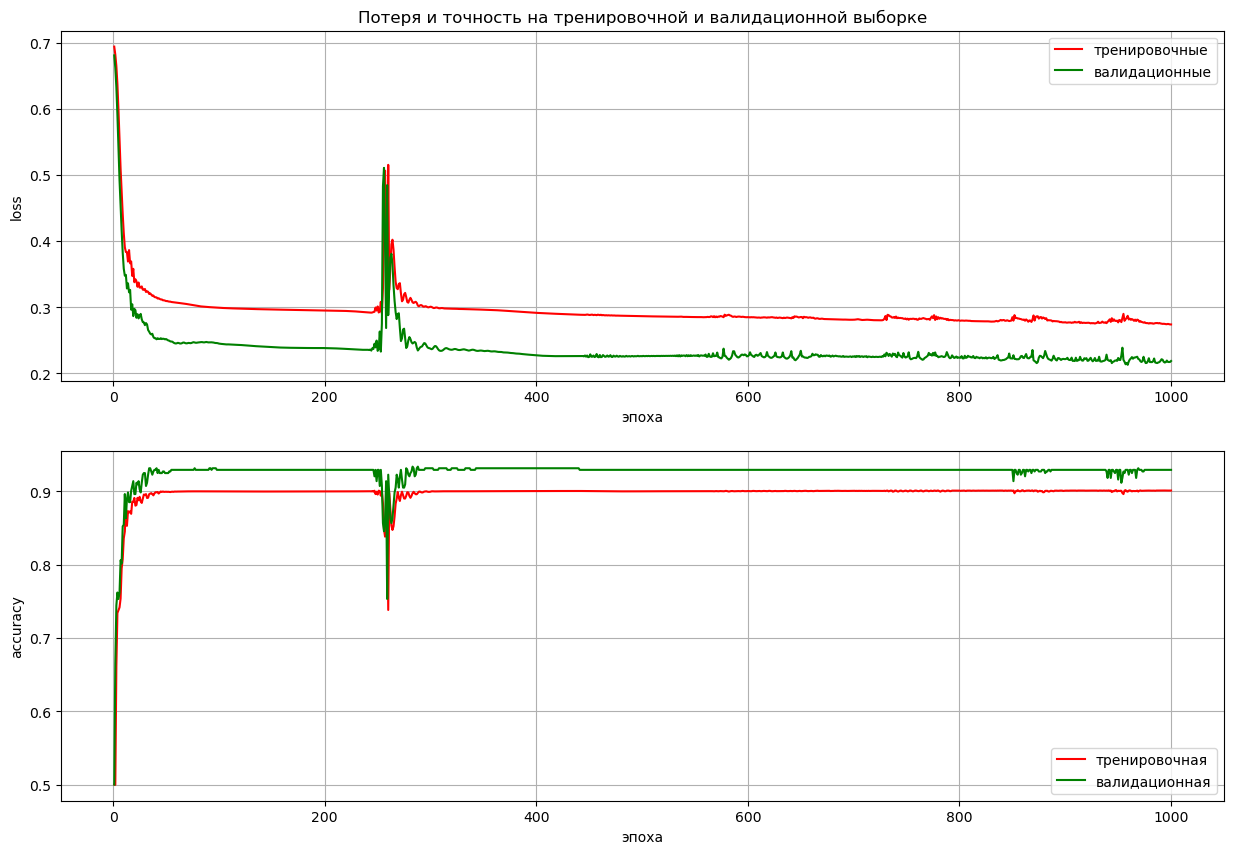

Время выполнения:  18.877004384994507
learning rate = 0.01
 num_neuros = 16
 optim = SGD
 epoches = 1000 

Epoch 1/1000 : train loss: 0.274, val loss: 0.219, train accuracy: 0.9012, val accuracy: 0.9295
Epoch 100/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9012, val accuracy: 0.9295
Epoch 200/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9012, val accuracy: 0.9295
Epoch 300/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 500/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 700/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 800/1000 : train loss: 0.274, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 900/100

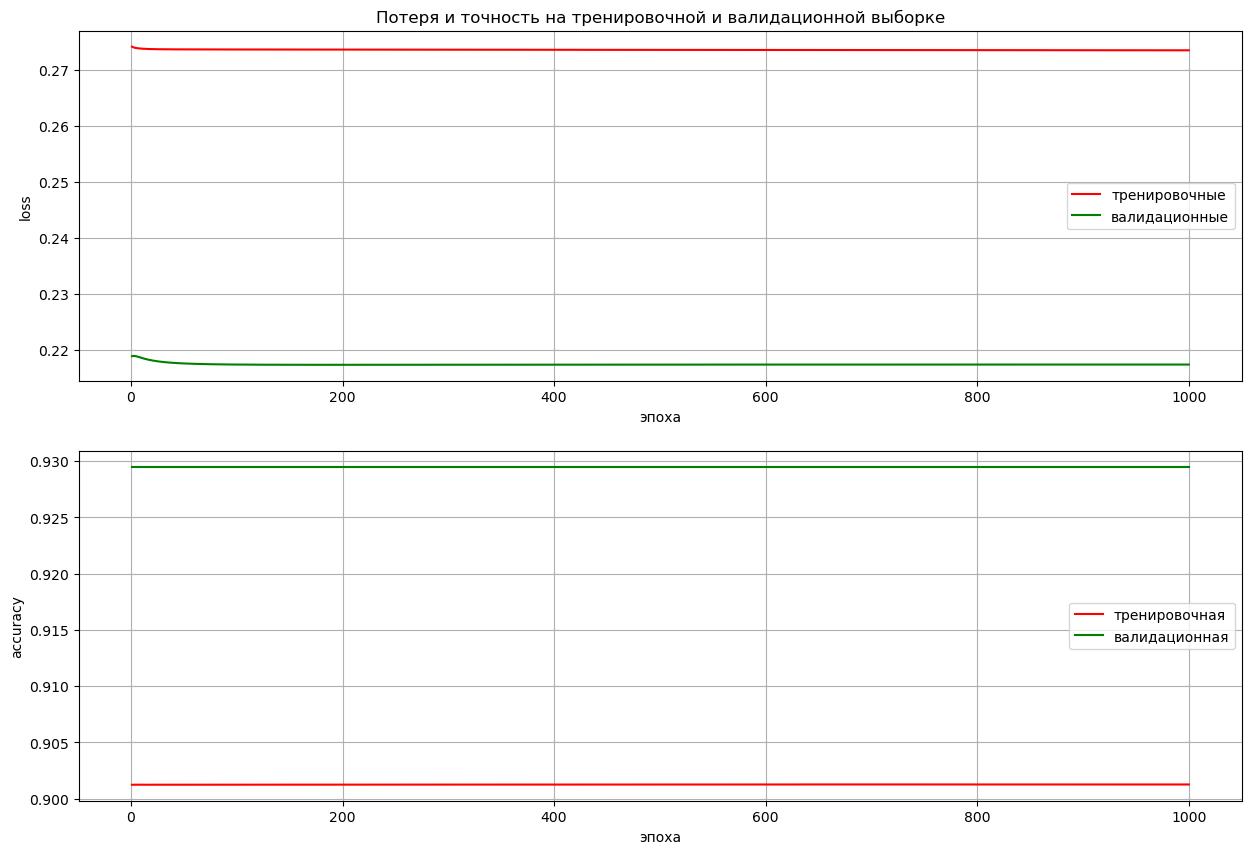

Время выполнения:  18.67456841468811
learning rate = 0.01
 num_neuros = 32
 optim = Adam
 epoches = 1000 

Epoch 1/1000 : train loss: 0.701, val loss: 0.667, train accuracy: 0.5003, val accuracy: 0.5022
Epoch 100/1000 : train loss: 0.297, val loss: 0.243, train accuracy: 0.8999, val accuracy: 0.9295
Epoch 200/1000 : train loss: 0.293, val loss: 0.233, train accuracy: 0.9004, val accuracy: 0.9317
Epoch 300/1000 : train loss: 0.283, val loss: 0.227, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 400/1000 : train loss: 0.278, val loss: 0.221, train accuracy: 0.9015, val accuracy: 0.9295
Epoch 500/1000 : train loss: 0.273, val loss: 0.213, train accuracy: 0.9019, val accuracy: 0.9295
Epoch 600/1000 : train loss: 0.273, val loss: 0.215, train accuracy: 0.9023, val accuracy: 0.9317
Epoch 700/1000 : train loss: 0.269, val loss: 0.205, train accuracy: 0.9020, val accuracy: 0.9339
Epoch 800/1000 : train loss: 0.269, val loss: 0.264, train accuracy: 0.9001, val accuracy: 0.9141
Epoch 900/100

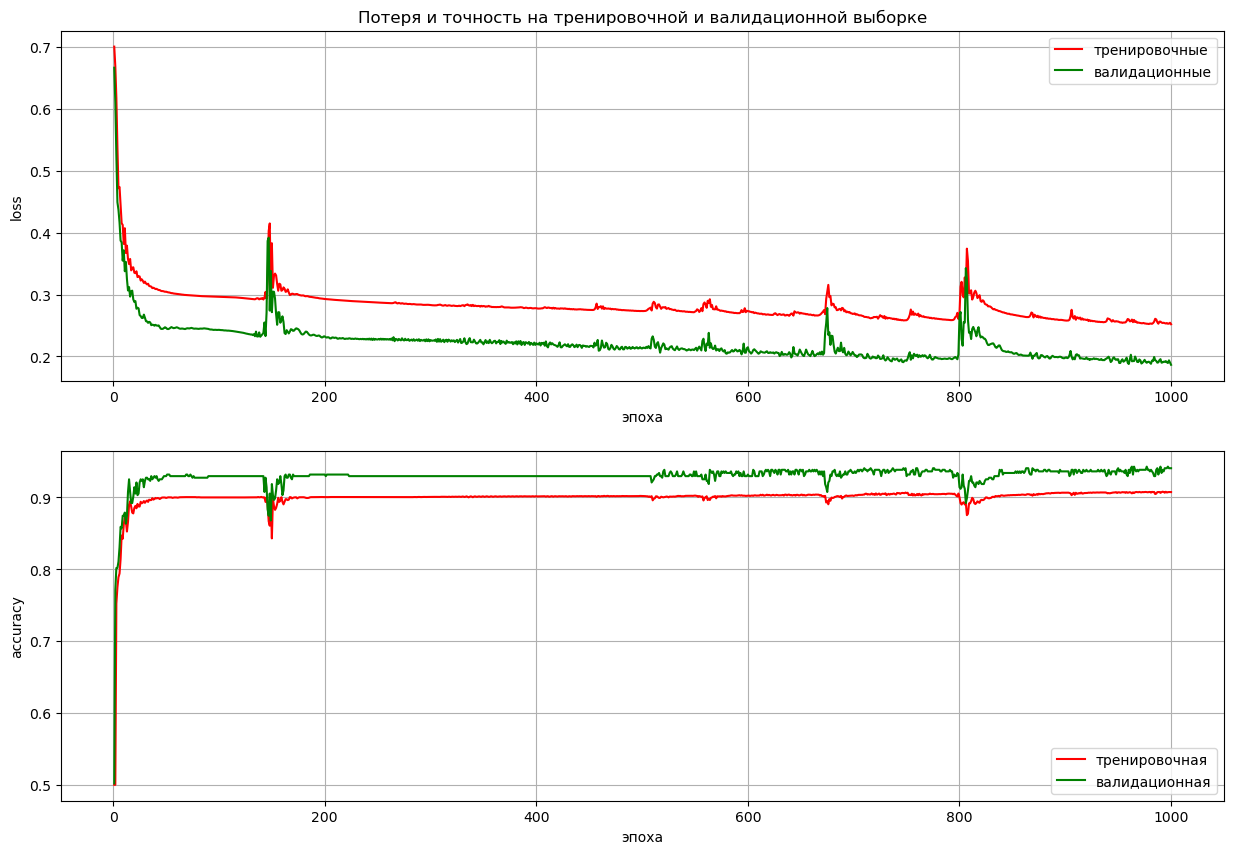

Время выполнения:  32.51636338233948
learning rate = 0.01
 num_neuros = 32
 optim = SGD
 epoches = 1000 

Epoch 1/1000 : train loss: 0.252, val loss: 0.187, train accuracy: 0.9076, val accuracy: 0.9405
Epoch 100/1000 : train loss: 0.251, val loss: 0.188, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 200/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 300/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 400/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 500/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 600/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 700/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9077, val accuracy: 0.9383
Epoch 800/1000 : train loss: 0.251, val loss: 0.189, train accuracy: 0.9078, val accuracy: 0.9383
Epoch 900/1000

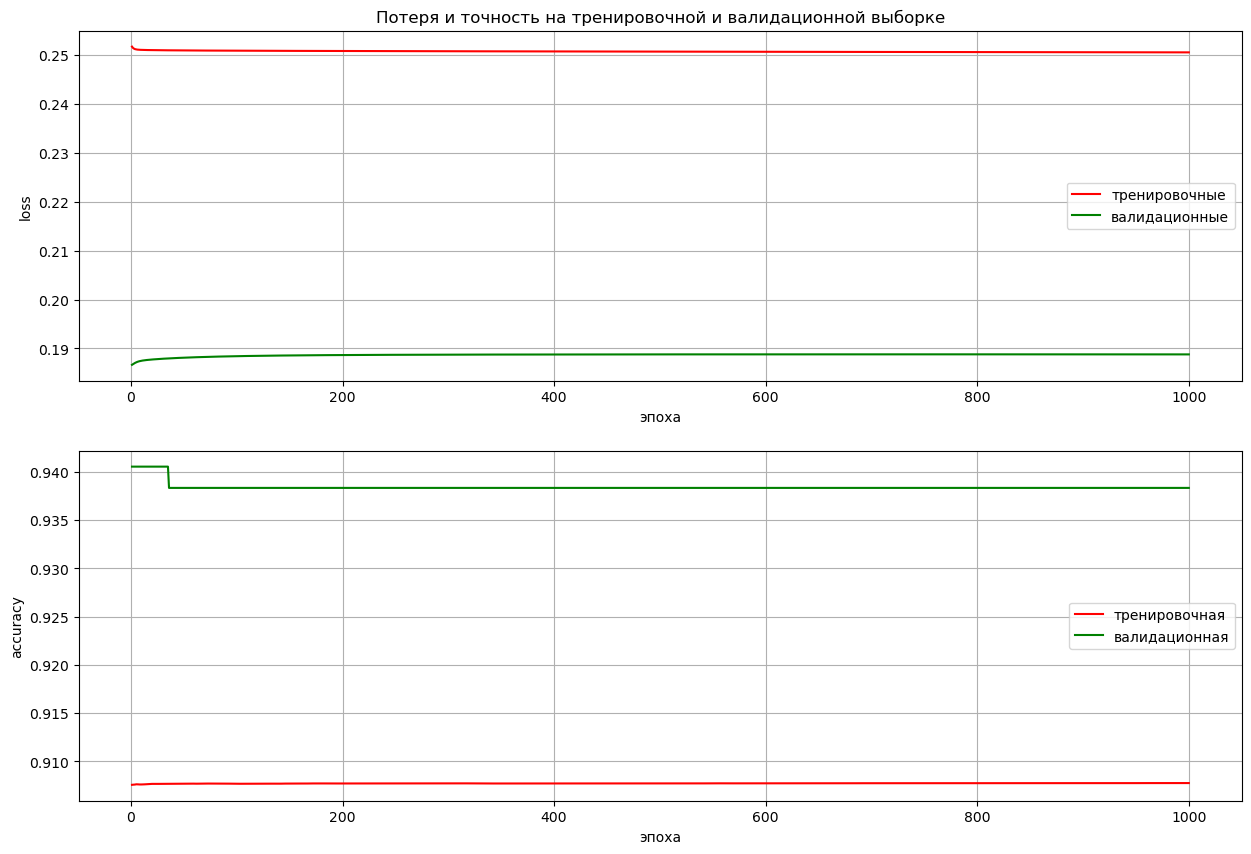

Время выполнения:  32.39205884933472
learning rate = 0.001
 num_neuros = 16
 optim = Adam
 epoches = 2000 

Epoch 1/2000 : train loss: 0.694, val loss: 0.693, train accuracy: 0.4526, val accuracy: 0.5396
Epoch 100/2000 : train loss: 0.348, val loss: 0.299, train accuracy: 0.8800, val accuracy: 0.8921
Epoch 200/2000 : train loss: 0.322, val loss: 0.271, train accuracy: 0.8935, val accuracy: 0.9207
Epoch 300/2000 : train loss: 0.307, val loss: 0.253, train accuracy: 0.8996, val accuracy: 0.9295
Epoch 400/2000 : train loss: 0.301, val loss: 0.247, train accuracy: 0.9000, val accuracy: 0.9273
Epoch 500/2000 : train loss: 0.299, val loss: 0.244, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.297, val loss: 0.242, train accuracy: 0.8999, val accuracy: 0.9317
Epoch 700/2000 : train loss: 0.296, val loss: 0.241, train accuracy: 0.8996, val accuracy: 0.9295
Epoch 800/2000 : train loss: 0.296, val loss: 0.240, train accuracy: 0.8998, val accuracy: 0.9295
Epoch 900/20

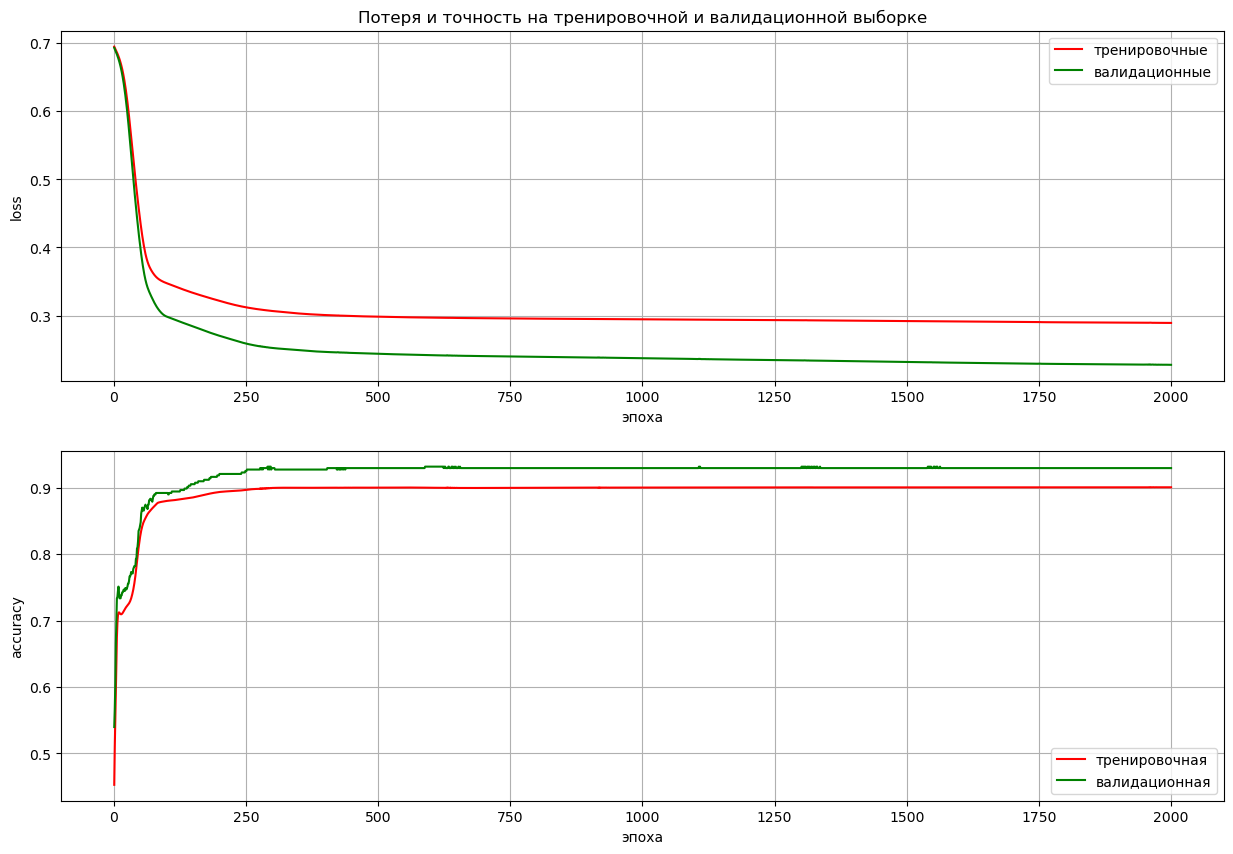

Время выполнения:  34.95853233337402
learning rate = 0.001
 num_neuros = 16
 optim = SGD
 epoches = 2000 

Epoch 1/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 100/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 200/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 300/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 400/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 500/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 700/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 800/2000 : train loss: 0.289, val loss: 0.228, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 900/200

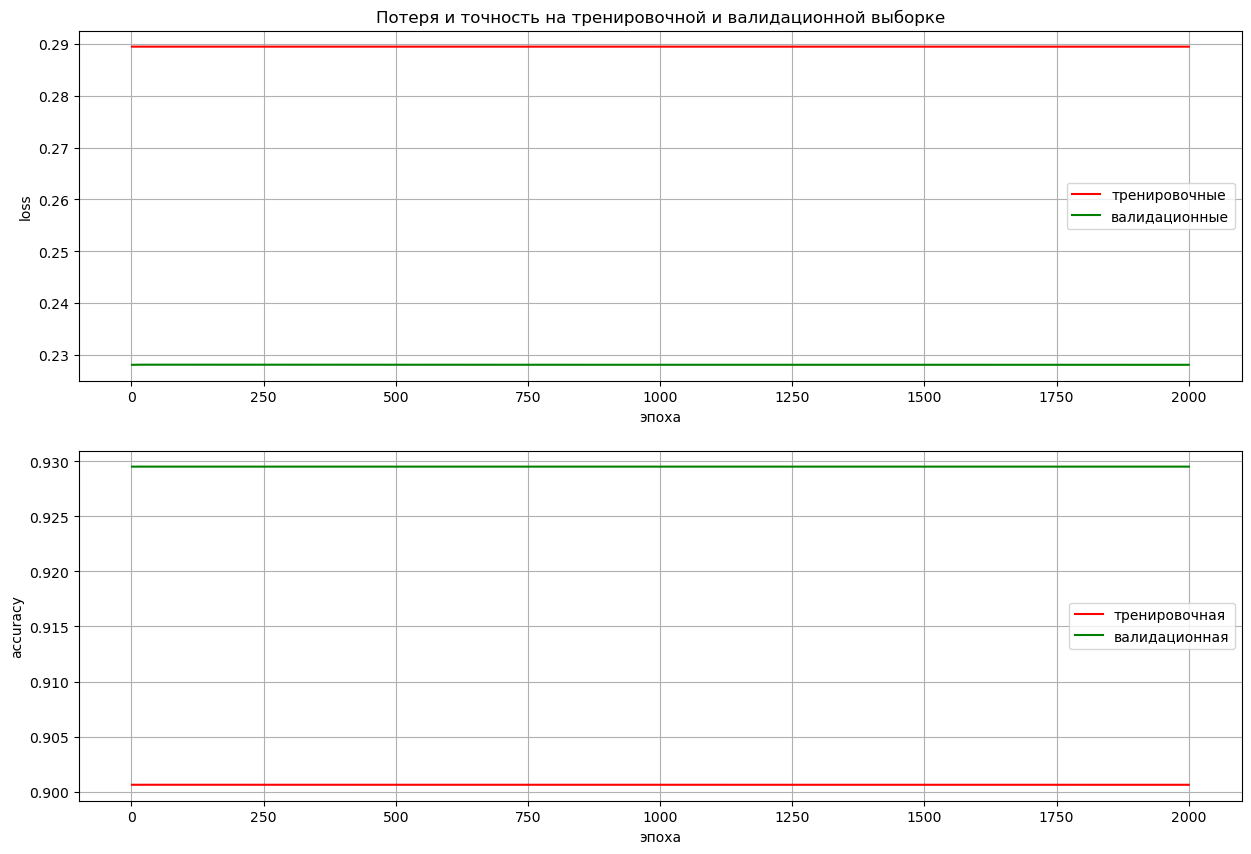

Время выполнения:  34.820833921432495
learning rate = 0.001
 num_neuros = 32
 optim = Adam
 epoches = 2000 

Epoch 1/2000 : train loss: 0.696, val loss: 0.691, train accuracy: 0.4399, val accuracy: 0.5044
Epoch 100/2000 : train loss: 0.329, val loss: 0.282, train accuracy: 0.8829, val accuracy: 0.9009
Epoch 200/2000 : train loss: 0.302, val loss: 0.248, train accuracy: 0.8998, val accuracy: 0.9273
Epoch 300/2000 : train loss: 0.297, val loss: 0.244, train accuracy: 0.9001, val accuracy: 0.9273
Epoch 400/2000 : train loss: 0.294, val loss: 0.239, train accuracy: 0.8998, val accuracy: 0.9295
Epoch 500/2000 : train loss: 0.291, val loss: 0.234, train accuracy: 0.8998, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.287, val loss: 0.230, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 700/2000 : train loss: 0.284, val loss: 0.226, train accuracy: 0.9003, val accuracy: 0.9295
Epoch 800/2000 : train loss: 0.280, val loss: 0.222, train accuracy: 0.9005, val accuracy: 0.9295
Epoch 900/2

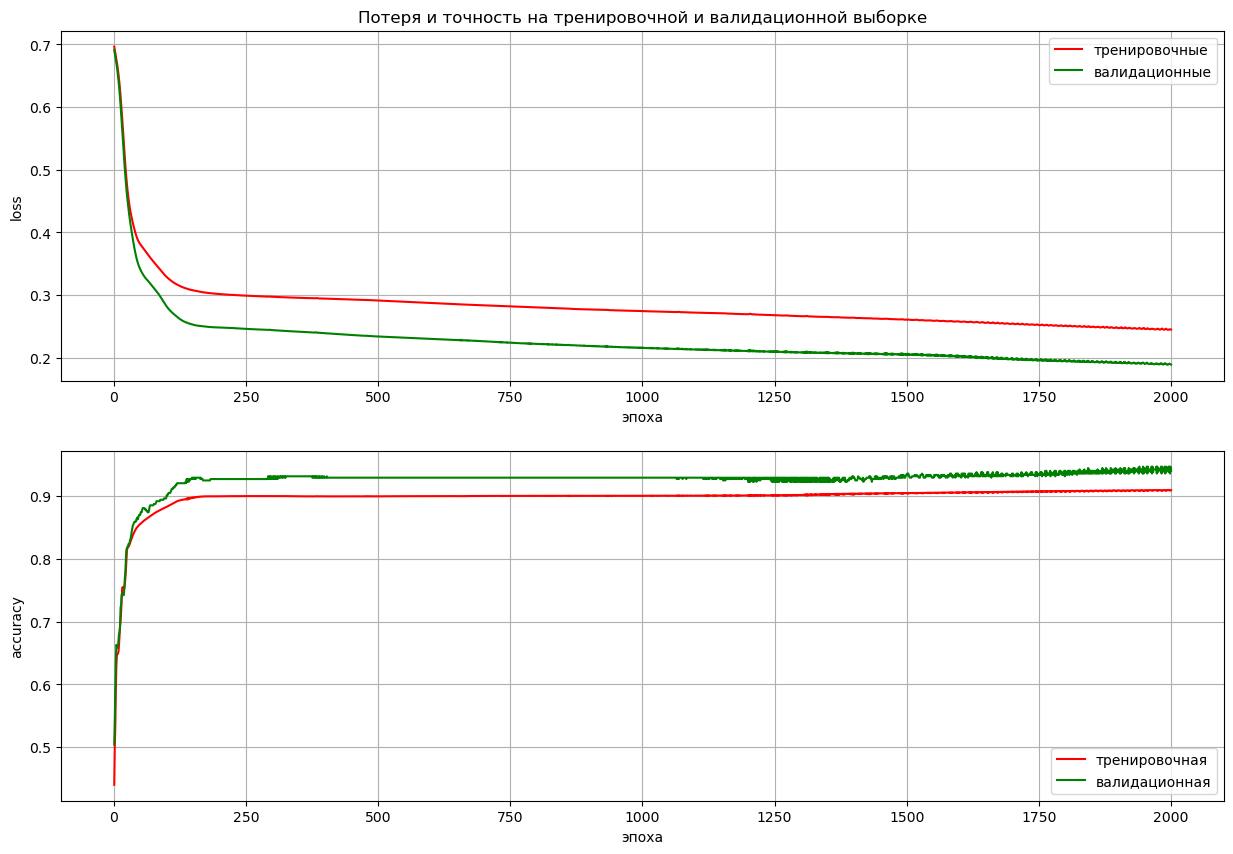

Время выполнения:  62.27149939537048
learning rate = 0.001
 num_neuros = 32
 optim = SGD
 epoches = 2000 

Epoch 1/2000 : train loss: 0.245, val loss: 0.189, train accuracy: 0.9097, val accuracy: 0.9427
Epoch 100/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 200/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 300/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 400/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 500/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 600/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 700/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 800/2000 : train loss: 0.244, val loss: 0.189, train accuracy: 0.9100, val accuracy: 0.9427
Epoch 900/200

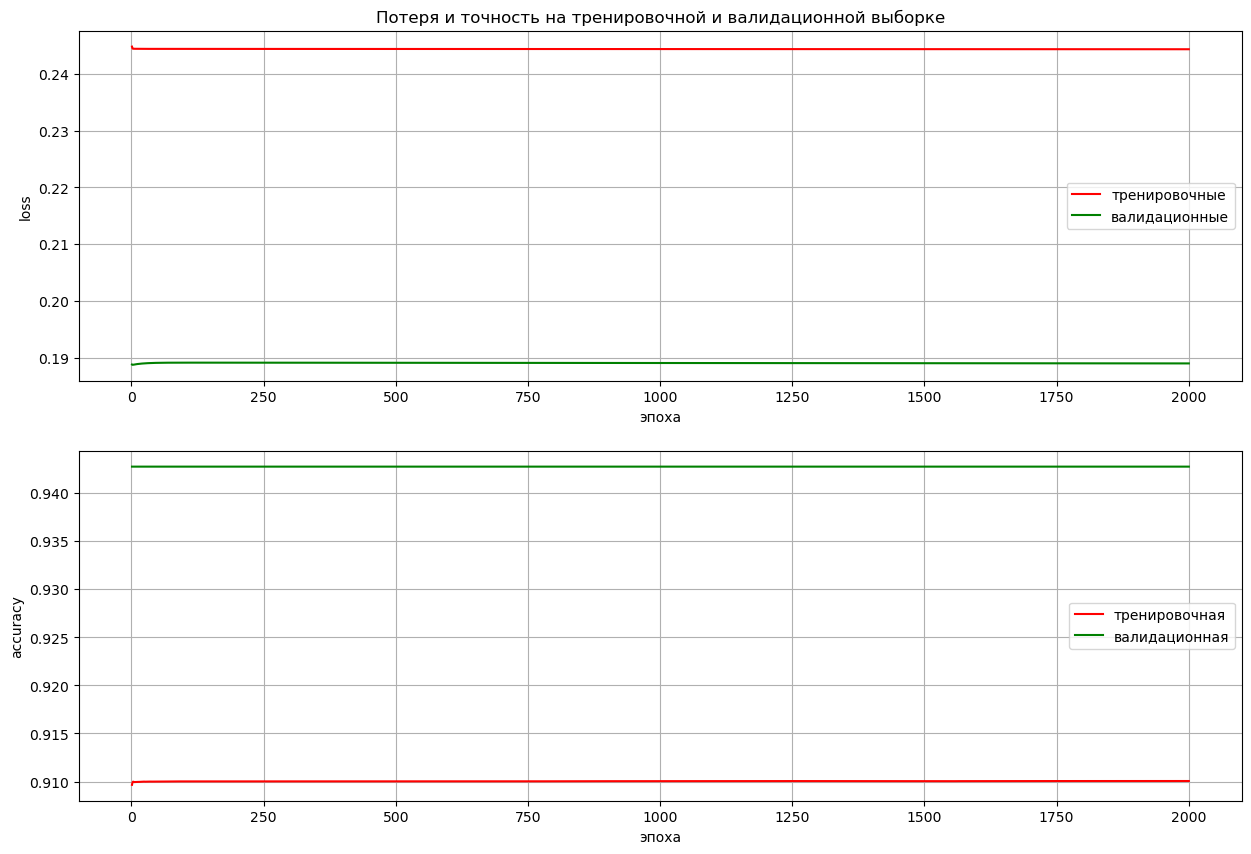

Время выполнения:  62.011070013046265
learning rate = 0.01
 num_neuros = 16
 optim = Adam
 epoches = 2000 

Epoch 1/2000 : train loss: 0.696, val loss: 0.683, train accuracy: 0.5003, val accuracy: 0.5000
Epoch 100/2000 : train loss: 0.298, val loss: 0.241, train accuracy: 0.8999, val accuracy: 0.9295
Epoch 200/2000 : train loss: 0.297, val loss: 0.238, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 300/2000 : train loss: 0.295, val loss: 0.236, train accuracy: 0.9001, val accuracy: 0.9295
Epoch 400/2000 : train loss: 0.294, val loss: 0.235, train accuracy: 0.9003, val accuracy: 0.9295
Epoch 500/2000 : train loss: 0.291, val loss: 0.231, train accuracy: 0.9003, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.286, val loss: 0.221, train accuracy: 0.9007, val accuracy: 0.9295
Epoch 700/2000 : train loss: 0.282, val loss: 0.217, train accuracy: 0.9013, val accuracy: 0.9295
Epoch 800/2000 : train loss: 0.276, val loss: 0.210, train accuracy: 0.9023, val accuracy: 0.9273
Epoch 900/20

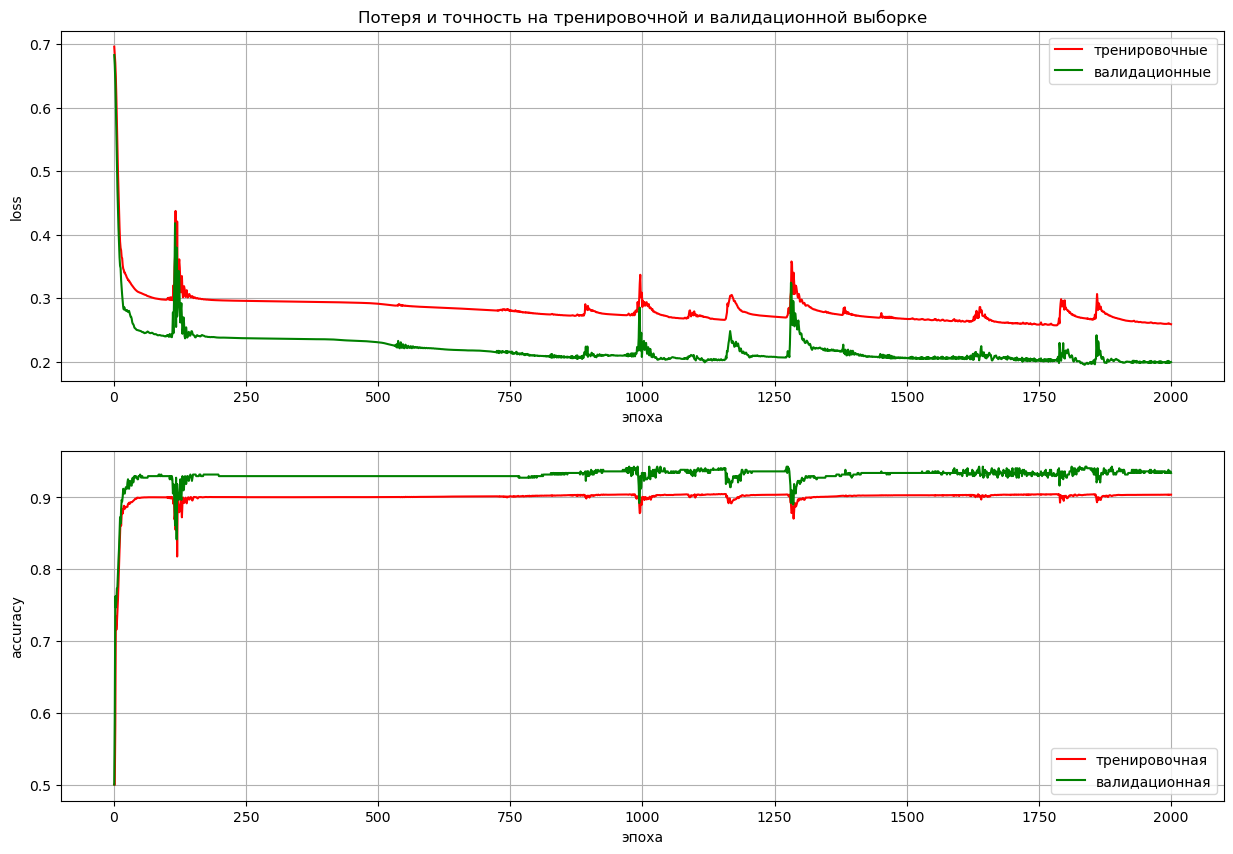

Время выполнения:  35.598286867141724
learning rate = 0.01
 num_neuros = 16
 optim = SGD
 epoches = 2000 

Epoch 1/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9036, val accuracy: 0.9339
Epoch 100/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 200/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 300/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 400/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 500/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 600/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 700/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 800/2000 : train loss: 0.259, val loss: 0.199, train accuracy: 0.9037, val accuracy: 0.9361
Epoch 900/200

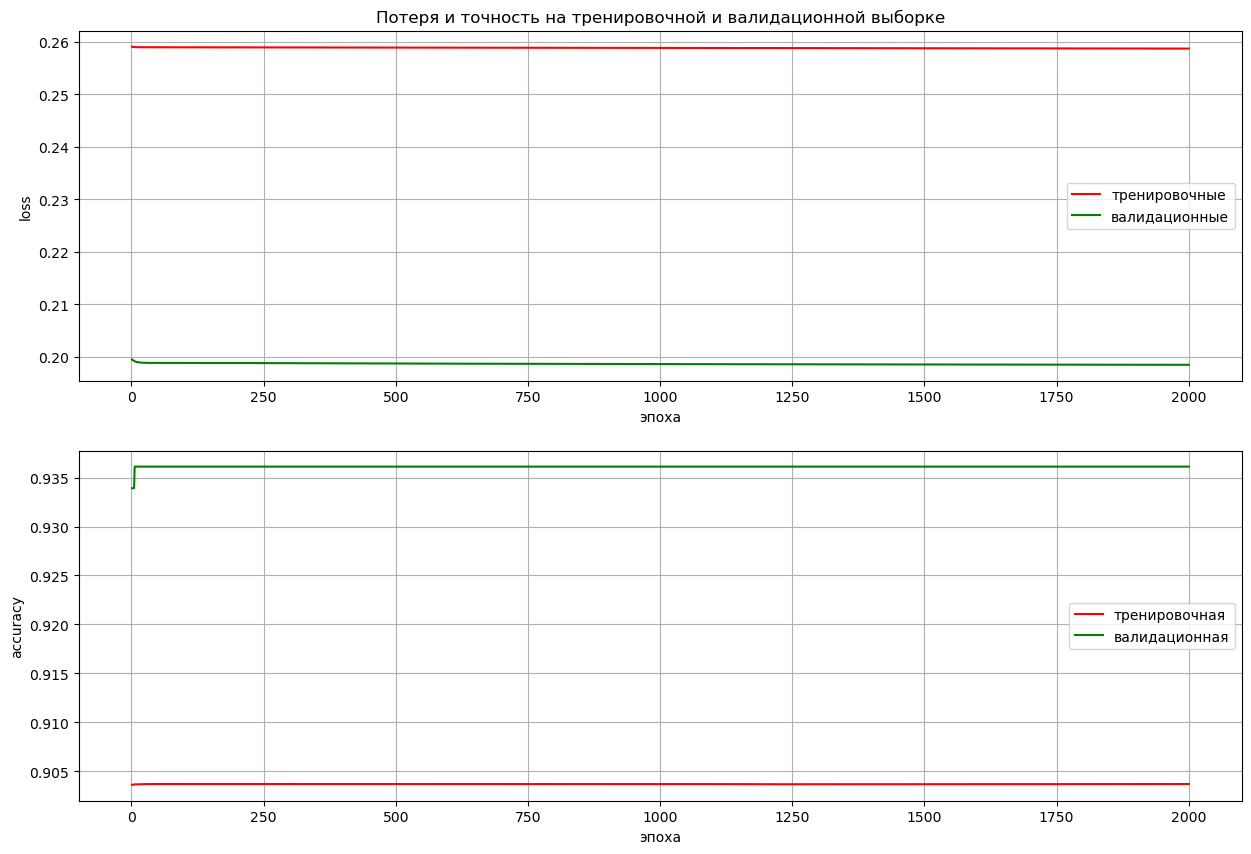

Время выполнения:  35.83413529396057
learning rate = 0.01
 num_neuros = 32
 optim = Adam
 epoches = 2000 

Epoch 1/2000 : train loss: 0.699, val loss: 0.650, train accuracy: 0.4997, val accuracy: 0.7819
Epoch 100/2000 : train loss: 0.317, val loss: 0.250, train accuracy: 0.8901, val accuracy: 0.9207
Epoch 200/2000 : train loss: 0.293, val loss: 0.235, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 300/2000 : train loss: 0.284, val loss: 0.230, train accuracy: 0.9003, val accuracy: 0.9295
Epoch 400/2000 : train loss: 0.278, val loss: 0.221, train accuracy: 0.9007, val accuracy: 0.9295
Epoch 500/2000 : train loss: 0.270, val loss: 0.210, train accuracy: 0.9015, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.277, val loss: 0.208, train accuracy: 0.9018, val accuracy: 0.9361
Epoch 700/2000 : train loss: 0.277, val loss: 0.209, train accuracy: 0.9004, val accuracy: 0.9339
Epoch 800/2000 : train loss: 0.260, val loss: 0.202, train accuracy: 0.9058, val accuracy: 0.9383
Epoch 900/200

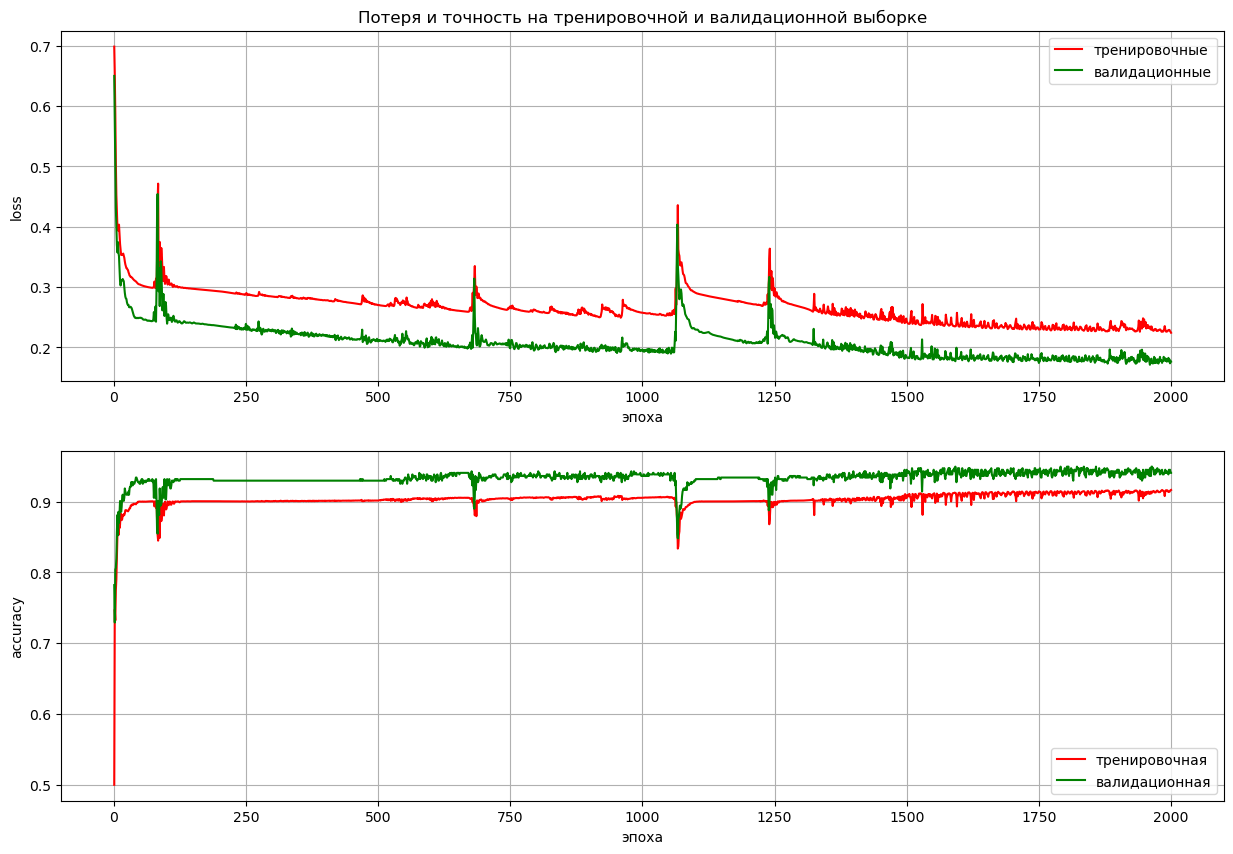

Время выполнения:  62.8555634021759
learning rate = 0.01
 num_neuros = 32
 optim = SGD
 epoches = 2000 

Epoch 1/2000 : train loss: 0.225, val loss: 0.176, train accuracy: 0.9166, val accuracy: 0.9427
Epoch 100/2000 : train loss: 0.280, val loss: 0.217, train accuracy: 0.9031, val accuracy: 0.9339
Epoch 200/2000 : train loss: 0.277, val loss: 0.215, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 300/2000 : train loss: 0.275, val loss: 0.215, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 400/2000 : train loss: 0.274, val loss: 0.214, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 500/2000 : train loss: 0.273, val loss: 0.214, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 600/2000 : train loss: 0.270, val loss: 0.212, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 700/2000 : train loss: 0.269, val loss: 0.212, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 800/2000 : train loss: 0.269, val loss: 0.212, train accuracy: 0.9031, val accuracy: 0.9383
Epoch 900/2000 

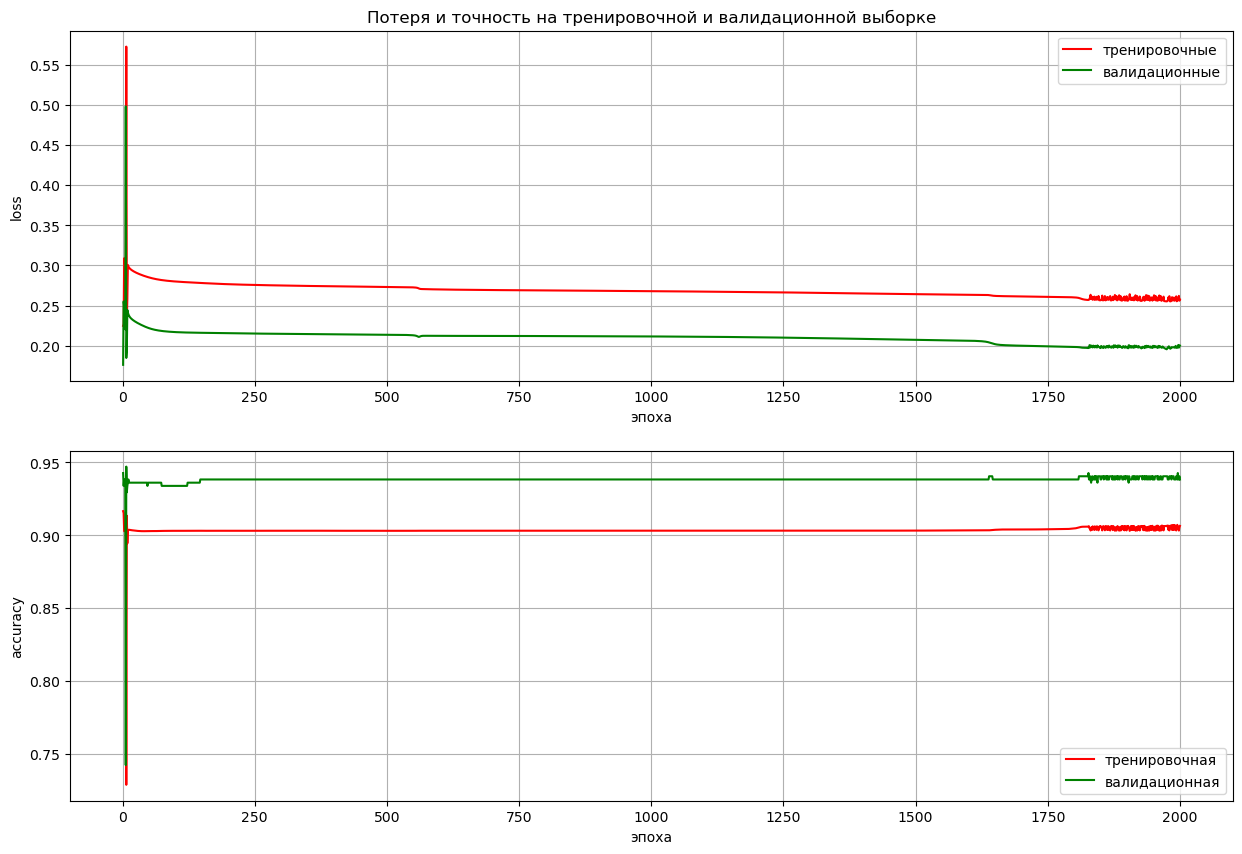

Время выполнения:  62.987693071365356


,learning_rate,epoches,output neuros 1 layer,optimizator,max train acc,val max acc
0,0.001,1000,16,Adam,0.900279,0.929515
0,0.001,1000,16,SGD,0.900095,0.929515
0,0.001,1000,32,Adam,0.902501,0.929515
0,0.001,1000,32,SGD,0.902445,0.929515
0,0.01,1000,16,Adam,0.901904,0.933921
0,0.01,1000,16,SGD,0.901269,0.929515
0,0.01,1000,32,Adam,0.907887,0.942731
0,0.01,1000,32,SGD,0.907764,0.938326
0,0.001,2000,16,Adam,0.900782,0.931718
0,0.001,2000,16,SGD,0.900623,0.929515


In [286]:
data_result_epoch_change = pd.DataFrame()

for epoches in range(1000,3000,1000):
    for learning_rate in [0.001, 0.01]:
        for neuros in [16,32]:
    
            model2 = ChinaNew(neuros)

            for name, optim in [('Adam', torch.optim.Adam(model2.parameters(), lr = learning_rate)),
                                ('SGD', torch.optim.SGD(model2.parameters(), lr = learning_rate))]:
            
            
                print('learning rate = {}\n num_neuros = {}\n optim = {}\n epoches = {} \n'.\
                    format(learning_rate,
                            neuros,
                            name,
                            epoches))
                
                start_time = time.time()

                train_max_acc , val_max_acc =\
                training_loop(

                    epoches = epoches,
                    model = model2,
                    loss_fn = nn.BCEWithLogitsLoss(),
                    optim = optim,

                    X_train = X_train,
                    y_train = y_train,

                    X_val = X_val_balance_down,
                    y_val = y_val_balance_down
                )

                end_time = time.time()
                delta_time = end_time - start_time

                print('Время выполнения: ', delta_time)

                slovar_odnogo_cikla = {'learning_rate': learning_rate,
                                       'epoches': epoches,
                                        'output neuros 1 layer': neuros,
                                        'optimizator': name,
                                        'max train acc': train_max_acc,
                                        'val max acc': val_max_acc}

                ser_slovar = pd.Series(slovar_odnogo_cikla)
                data_result_epoch_change = pd.concat([data_result_epoch_change,
                                                      ser_slovar], axis = 1)


data_result_epoch_change.T

In [288]:
data_result_epoch_change.T.sort_values(by = 'max train acc', ascending = False).head()

,learning_rate,epoches,output neuros 1 layer,optimizator,max train acc,val max acc
0,0.01,2000,32,Adam,0.916423,0.949339
0,0.001,2000,32,SGD,0.910059,0.942731
0,0.001,2000,32,Adam,0.910038,0.947137
0,0.01,1000,32,Adam,0.907887,0.942731
0,0.01,1000,32,SGD,0.907764,0.938326


Epoch 1/2000 : train loss: 0.693, val loss: 0.655, train accuracy: 0.5018, val accuracy: 0.5000
Epoch 100/2000 : train loss: 0.297, val loss: 0.240, train accuracy: 0.9007, val accuracy: 0.9295
Epoch 200/2000 : train loss: 0.288, val loss: 0.232, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 300/2000 : train loss: 0.282, val loss: 0.221, train accuracy: 0.9004, val accuracy: 0.9295
Epoch 400/2000 : train loss: 0.305, val loss: 0.244, train accuracy: 0.9003, val accuracy: 0.9317
Epoch 500/2000 : train loss: 0.290, val loss: 0.230, train accuracy: 0.9006, val accuracy: 0.9295
Epoch 600/2000 : train loss: 0.282, val loss: 0.214, train accuracy: 0.9014, val accuracy: 0.9317
Epoch 700/2000 : train loss: 0.276, val loss: 0.214, train accuracy: 0.9016, val accuracy: 0.9295
Epoch 800/2000 : train loss: 0.268, val loss: 0.200, train accuracy: 0.9029, val accuracy: 0.9361
Epoch 900/2000 : train loss: 0.261, val loss: 0.202, train accuracy: 0.9060, val accuracy: 0.9361
Epoch 1000/2000 : trai

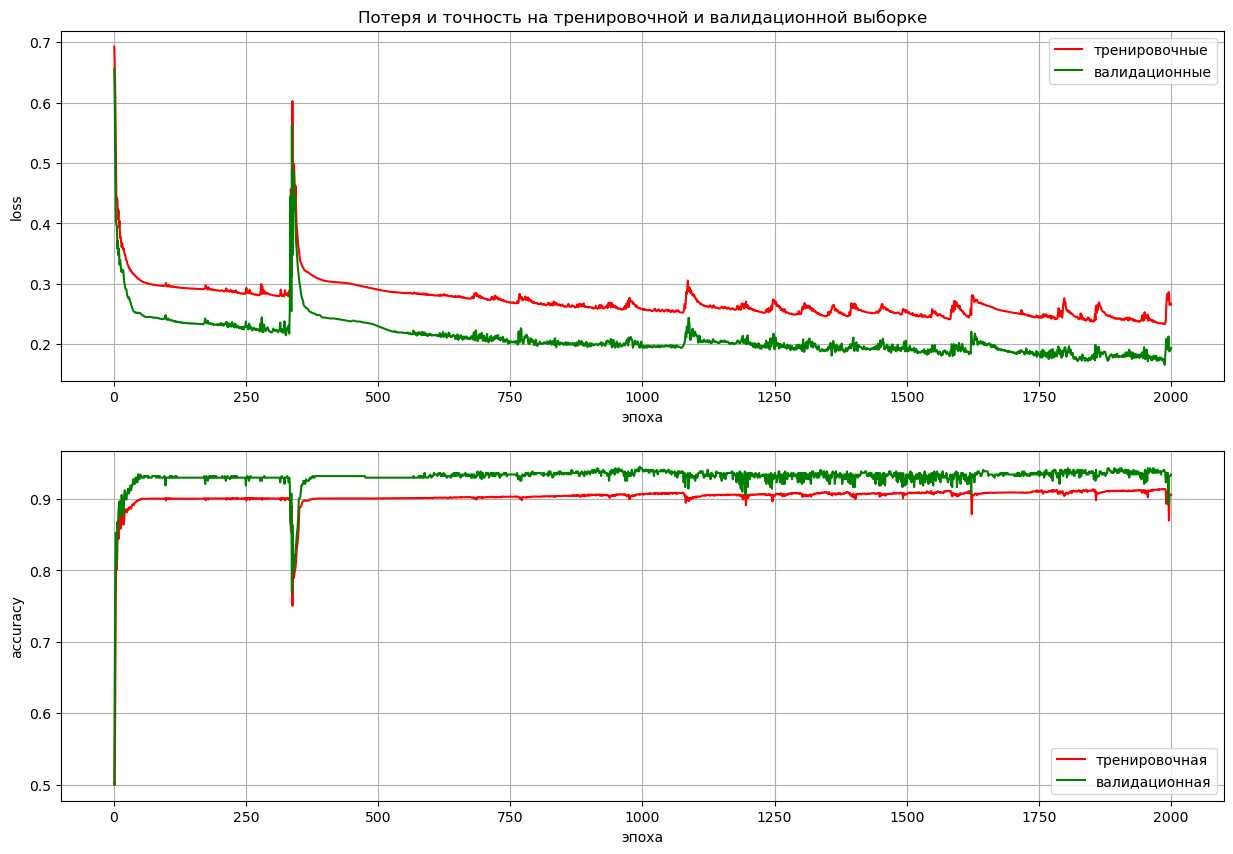

In [308]:
model = ChinaNew(32)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.01)


train_max, val_max, train_acc_spisok, val_acc_spisok =\
training_loop(

    epoches = 2000,
    model = model,
    loss_fn = loss_fn,
    optim = optim,

    X_train = X_train,
    y_train = y_train,

    X_val = X_val_balance_down,
    y_val = y_val_balance_down
)

In [309]:
ChinaNew(32)

Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=1, bias=True)
)

# Итог

Мы выявили лучшую модель:

- ChinaNew(32) (её слои записаны строкой выше)
- lr = 0.01
- optim = Adam
- epoches = 2000


Точность на тренировке: 0.94
Точность на валидавции: 0.91

Точность на валидации выше, т.к. там всего 454 сбалансированных оразца, в свою очередь, тренировочная состоит из 
9 * (10**5) образцов


Как был предобработан датасет:

- все признаки, кроме временных, являлись категориальными с большим количеством уникальных значений (более 100 на каждом признаке) --> кодировали количеством кликов (заполняли признак кол-вом по всему признаку)
- временные признаки были разбиты на день -- час -- минута клика (год и месяц у всех признаков совпадали)


Дальнейшие действия:

- Натренировать эту модель на всех возможных образцах (тренировочные + валидационные)
